In [75]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import mplhep
import math
import boost_histogram as bh

In [76]:
# data = {"cc_e_four_vars_unweighted ": uproot.open("../logs/energy_regression_train/2026-01-28_13-47-35/results.root"),
# "cc_e_four_vars_reweighted ": uproot.open("../logs/energy_regression_train/2026-01-28_17-07-21/results.root"),
# "cc_e_three_vars_reweighted": uproot.open("../logs/energy_regression_train/2026-01-29_16-33-59/results.root"),
# "cc_e_three_vars_unweighted": uproot.open("../logs/energy_regression_train/2026-01-28_13-47-35/results.root"),}

In [77]:
data = {"CC Nue 5 mm Tungsten": uproot.open("/home/benwilson/work/EnergyRegressor/logs/energy_regression_train/2026-02-05_11-21-35/results.root"),
"CC Nue 8 mm Tungsten": uproot.open("/home/benwilson/work/EnergyRegressor/logs/energy_regression_train/2026-02-06_10-57-17/results.root"),
"CC Nue 5 mm Tungsten with Scints": uproot.open("/home/benwilson/work/EnergyRegressor/logs/energy_regression_train/2026-02-09_18-18-37/results.root"),
"CC Nue 8 mm Tungsten with Scints": uproot.open("/home/benwilson/work/EnergyRegressor/logs/energy_regression_train/2026-02-10_15-49-21/results.root")}

In [78]:
target_vars = ["E_nu", "E_lep", "Eta_lep", "E_had"]

In [79]:
def get_histograms(root_file, variable):

    file_keys = root_file.keys()

    try:
        resolution_hists = [root_file[k].to_boost() for k in file_keys if f"{variable}/resHists/" in k and "/bias" not in k and "/stats" not in k]
        resolution_hists_bias_corr = [root_file[k].to_boost() for k in file_keys if f"{variable}/resHistsBiasCorr/" in k and "/bias" not in k and "/stats" not in k]
        true_v_reco = root_file[f"{variable}/true_vs_reco"].to_boost()
        true_v_reco_bias_corr = root_file[f"{variable}/true_vs_reco_BiasCorr"].to_boost()

        stats = root_file[f"{variable}/resHists/stats/"].arrays()
        stats_bias_corr = root_file[f"{variable}/resHistsBiasCorr/stats/"].arrays()

    except KeyError:
        return []

    return resolution_hists, resolution_hists_bias_corr, true_v_reco, true_v_reco_bias_corr, stats, stats_bias_corr

In [80]:
hists = {}
for var in target_vars:
    tmp = {}
    for name, file in data.items():
        tmp[name] = get_histograms(file, var)
    hists[var] = tmp

In [81]:
def plot_true_v_reco(hists, index, title="", var_latex="", unit=""):
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    fig, ax = plt.subplots(nrows=(math.ceil(len(hists.keys())/2)), ncols=2, figsize=(20,10*(math.ceil(len(hists.keys())/2))))
    ax = ax.flatten()

    for i, (name, hist_list) in enumerate(hists.items()):
        h2 = hist_list[index]

        mplhep.hist2dplot(h2, ax=ax[i], norm="log",)
        ax[i].set_title(name, loc="right")
        ax[i].set_title(title, loc="left")
        ax[i].set_xlabel(rf"${var_latex}$ True {unit}")
        ax[i].set_ylabel(rf"${var_latex}$ Pred {unit}")
        
        x = np.linspace(
                0,
                3500,
                100,
            )
        ax[i].plot(x, x, "r--", linewidth=1)
        

In [82]:
def plot_stats(hists, index, title="", var_latex="", unit=""):
    fig, ax = plt.subplots()

    for j, (name, hist_list) in enumerate(hists.items()):
        
        stats = hist_list[index]

        centres = [np.mean(p) for p in stats["param_ranges"]]

        ax.errorbar(centres, stats["means"], yerr=stats["std_devs"], label=name, linestyle="", marker=".", capsize=2)
        ax.set_title(title, loc="left")
        ax.set_xlabel(rf"${var_latex}$ True {unit}")
        ax.set_ylabel(rf"Mean ${var_latex}$ Resolution {unit}")
        ax.set_ylim(-0.5, 0.5)
        ax.legend()
        
    

In [83]:
def plot_res_hists(hists, index, title="", var_latex="", unit=""):

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
    ax = ax.flatten()

    for j, (name, hist_list) in enumerate(hists.items()):
        for i, h in enumerate(hist_list[index]):

            stats = hist_list[4]
            ranges = stats["param_ranges"]
            range_str = f"{ranges[i][0]} - {ranges[i][1]} {unit}"

            mplhep.histplot(h[::bh.rebin(3)], ax=ax[i], label=name, histtype='step', yerr=0, alpha=1)
            ax[i].set_title(range_str, loc="right")
            ax[i].set_title(title, loc="left")
            ax[i].set_xlabel(rf"${var_latex}$ Resolution")
            ax[i].legend()


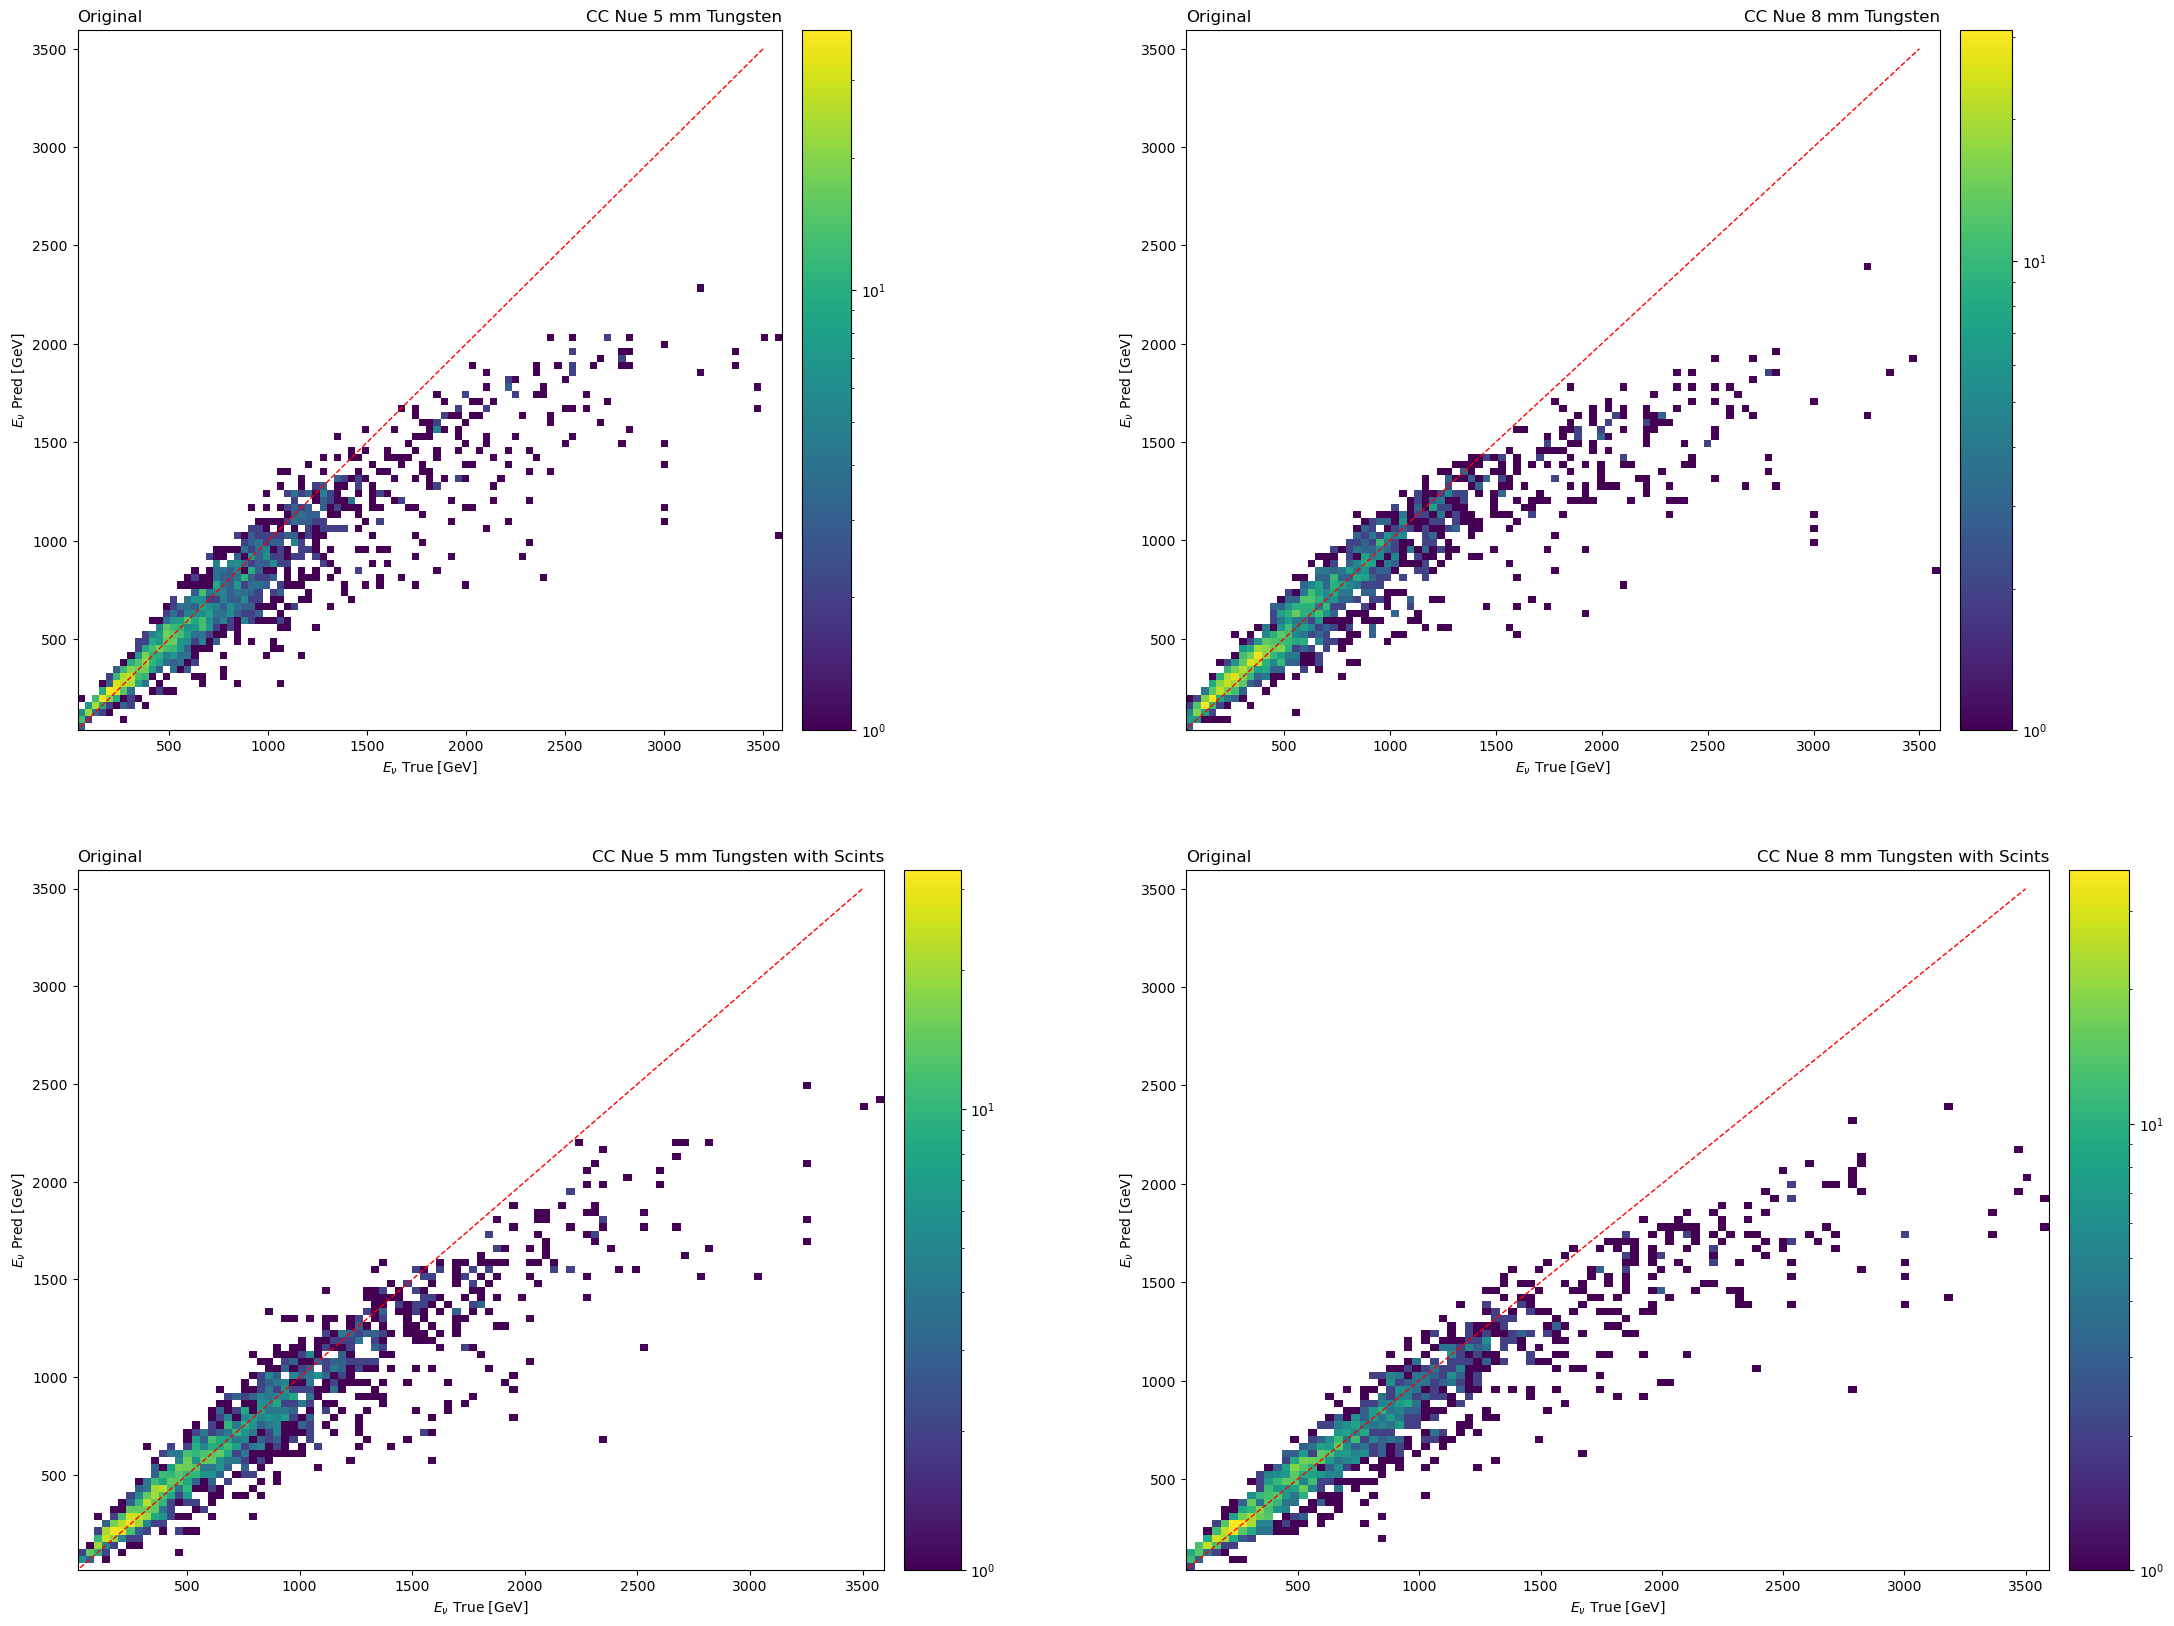

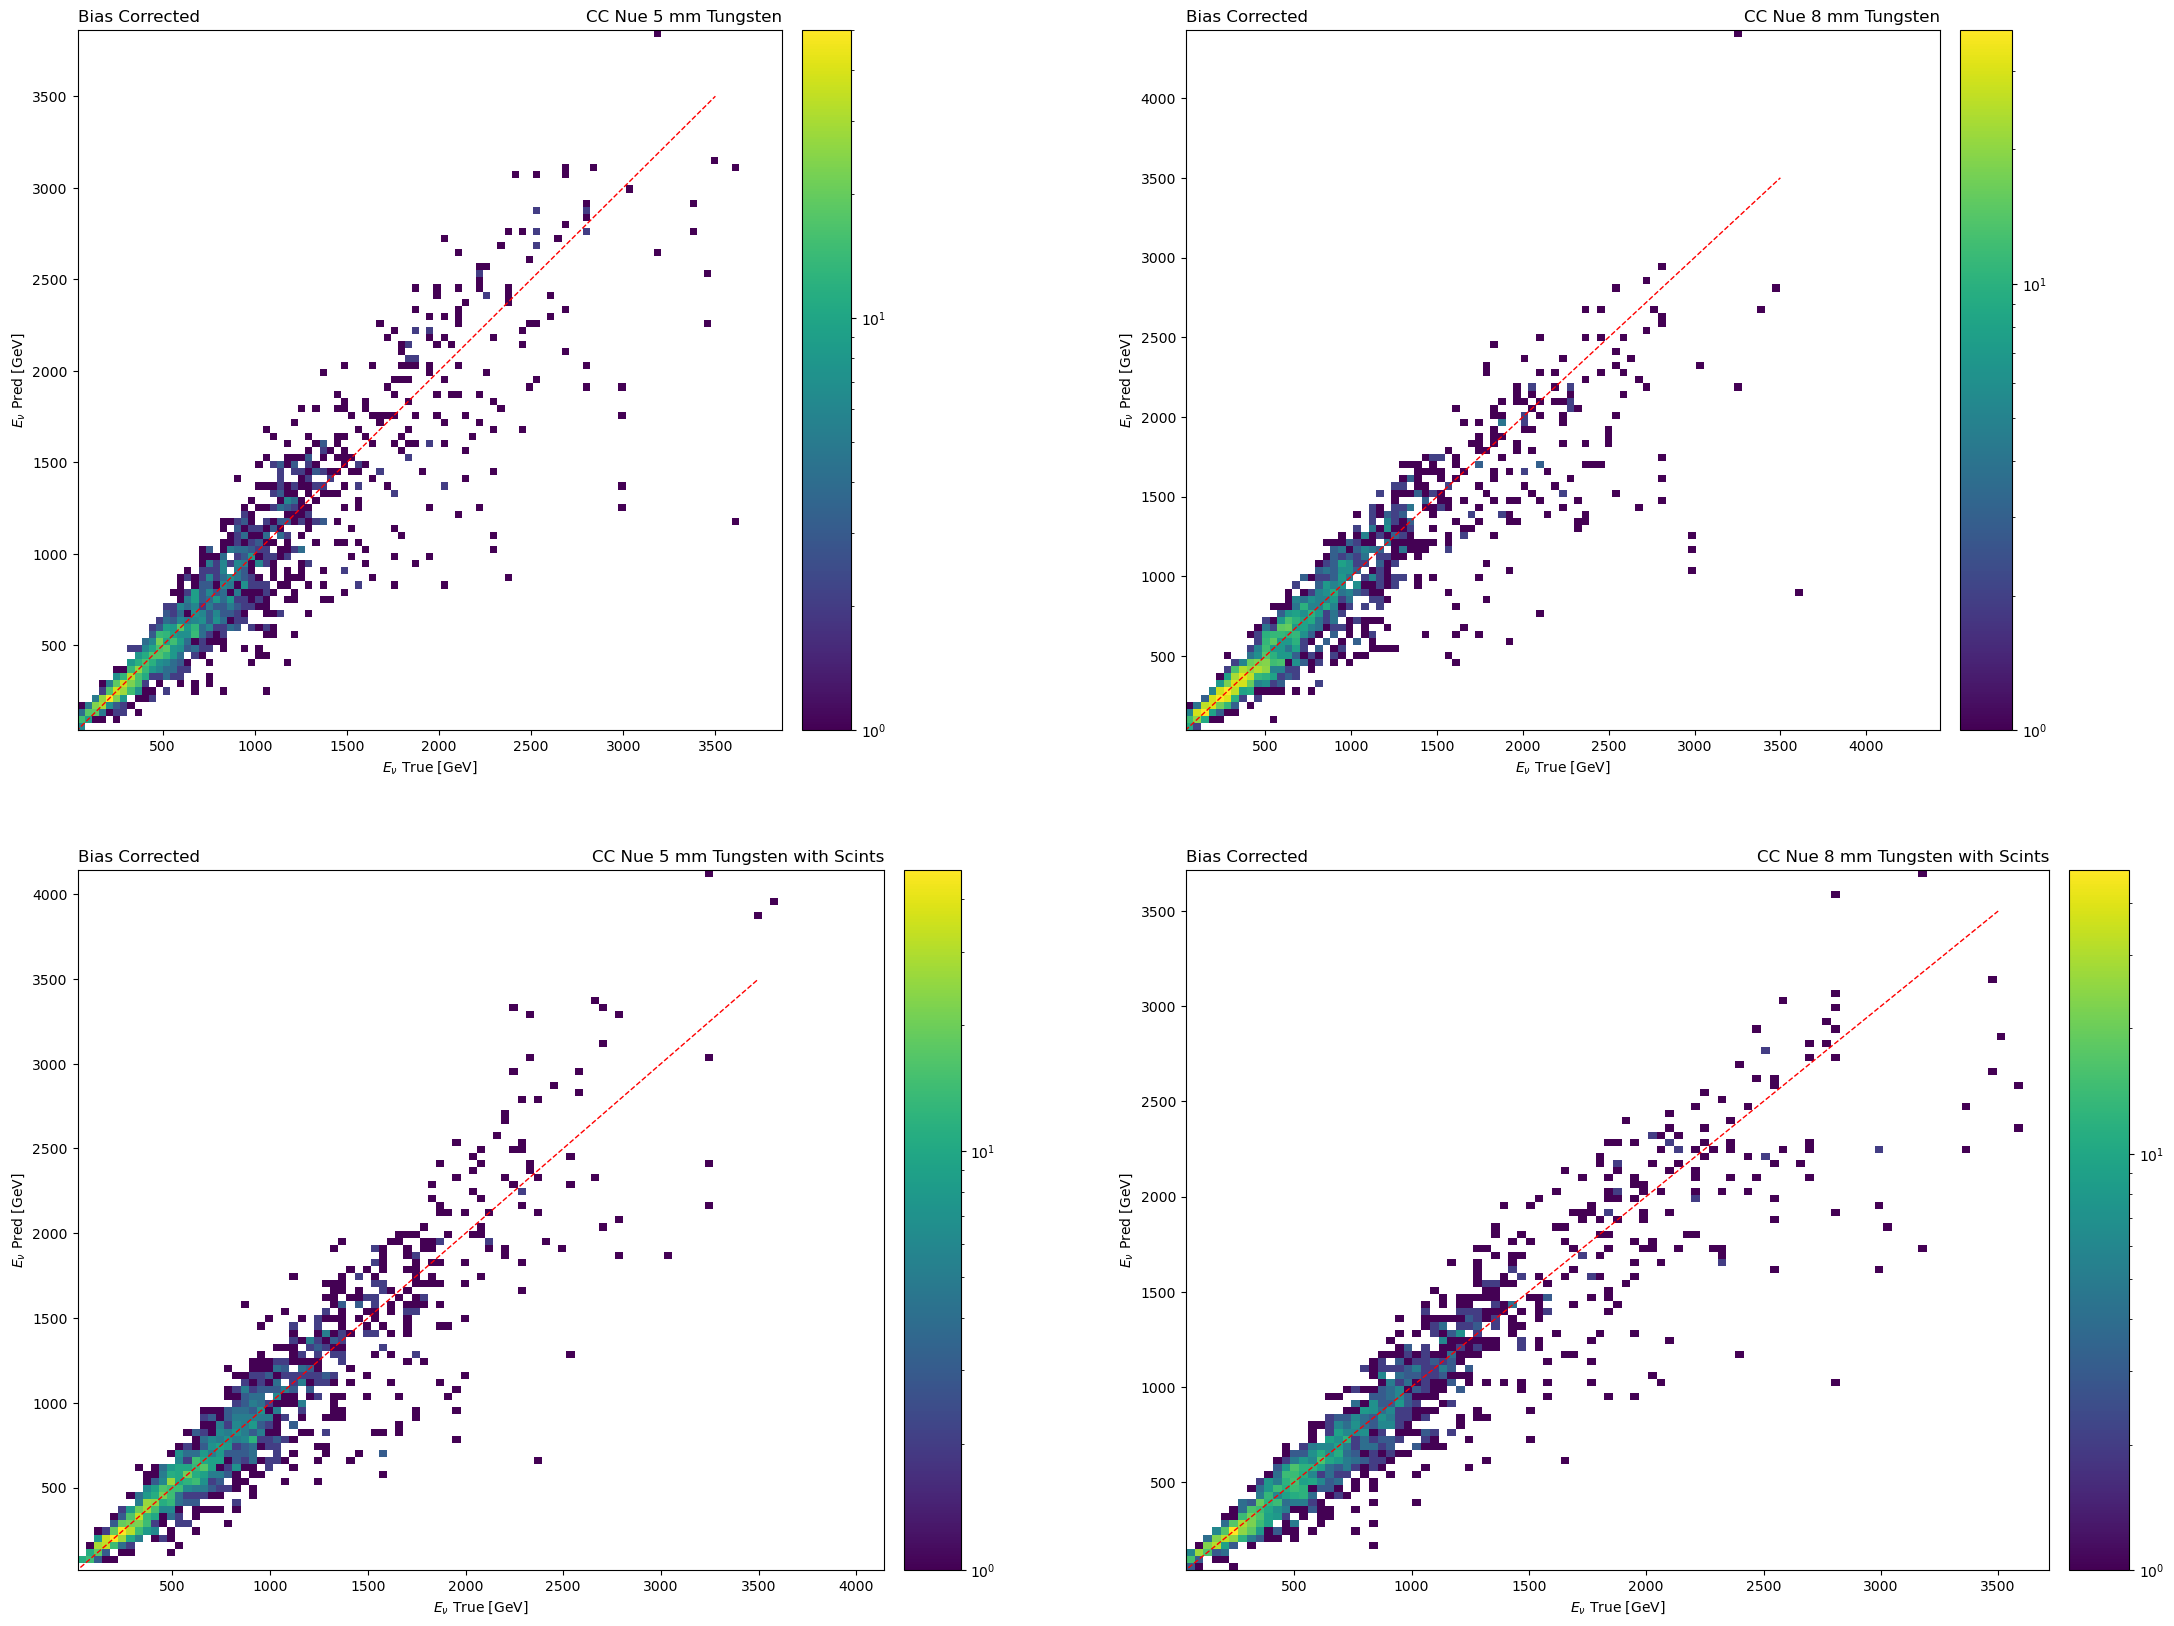

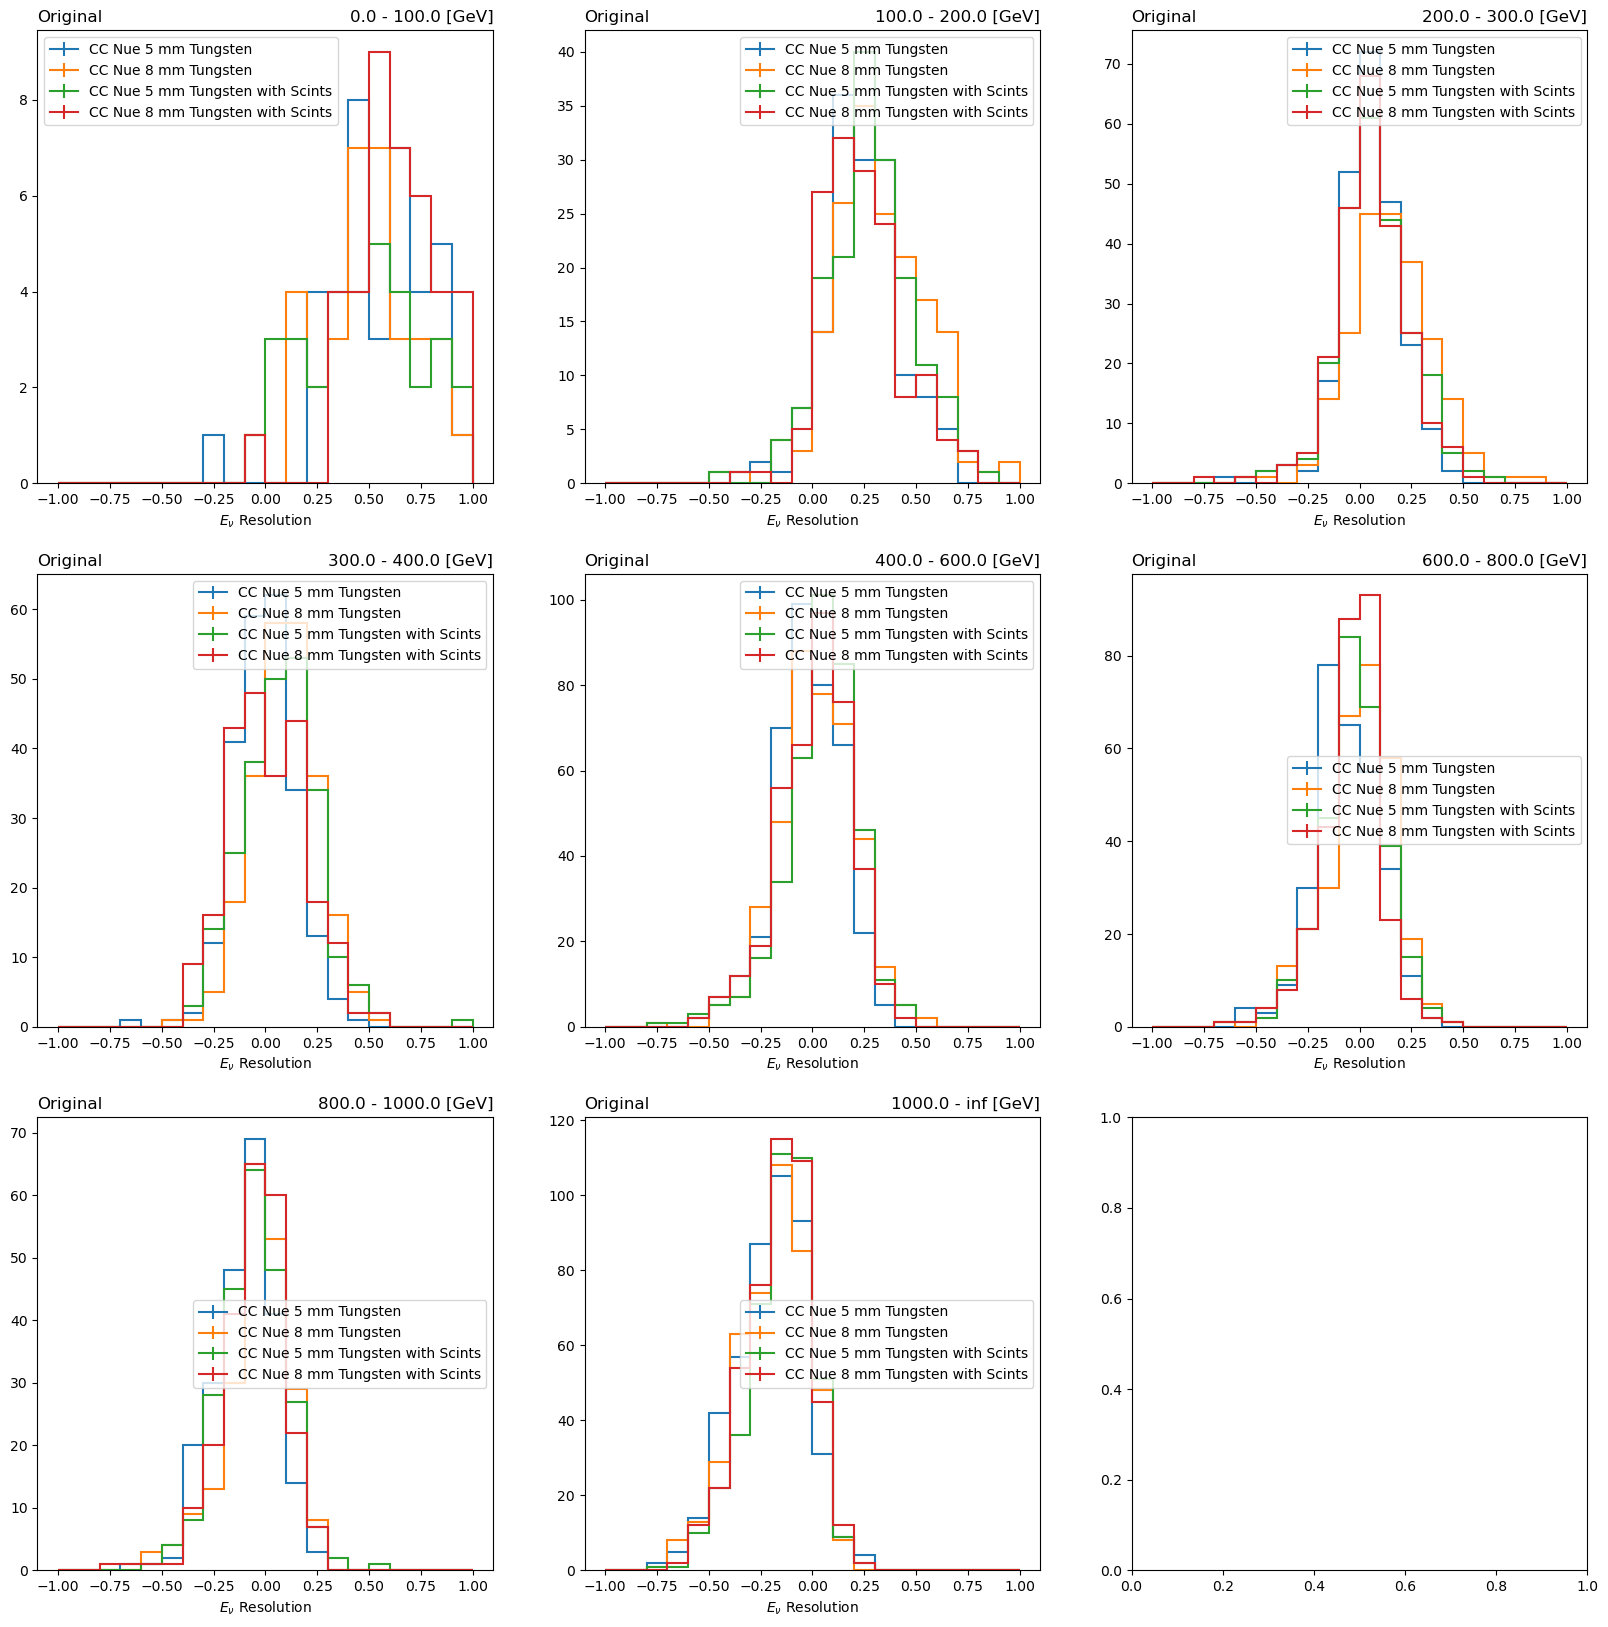

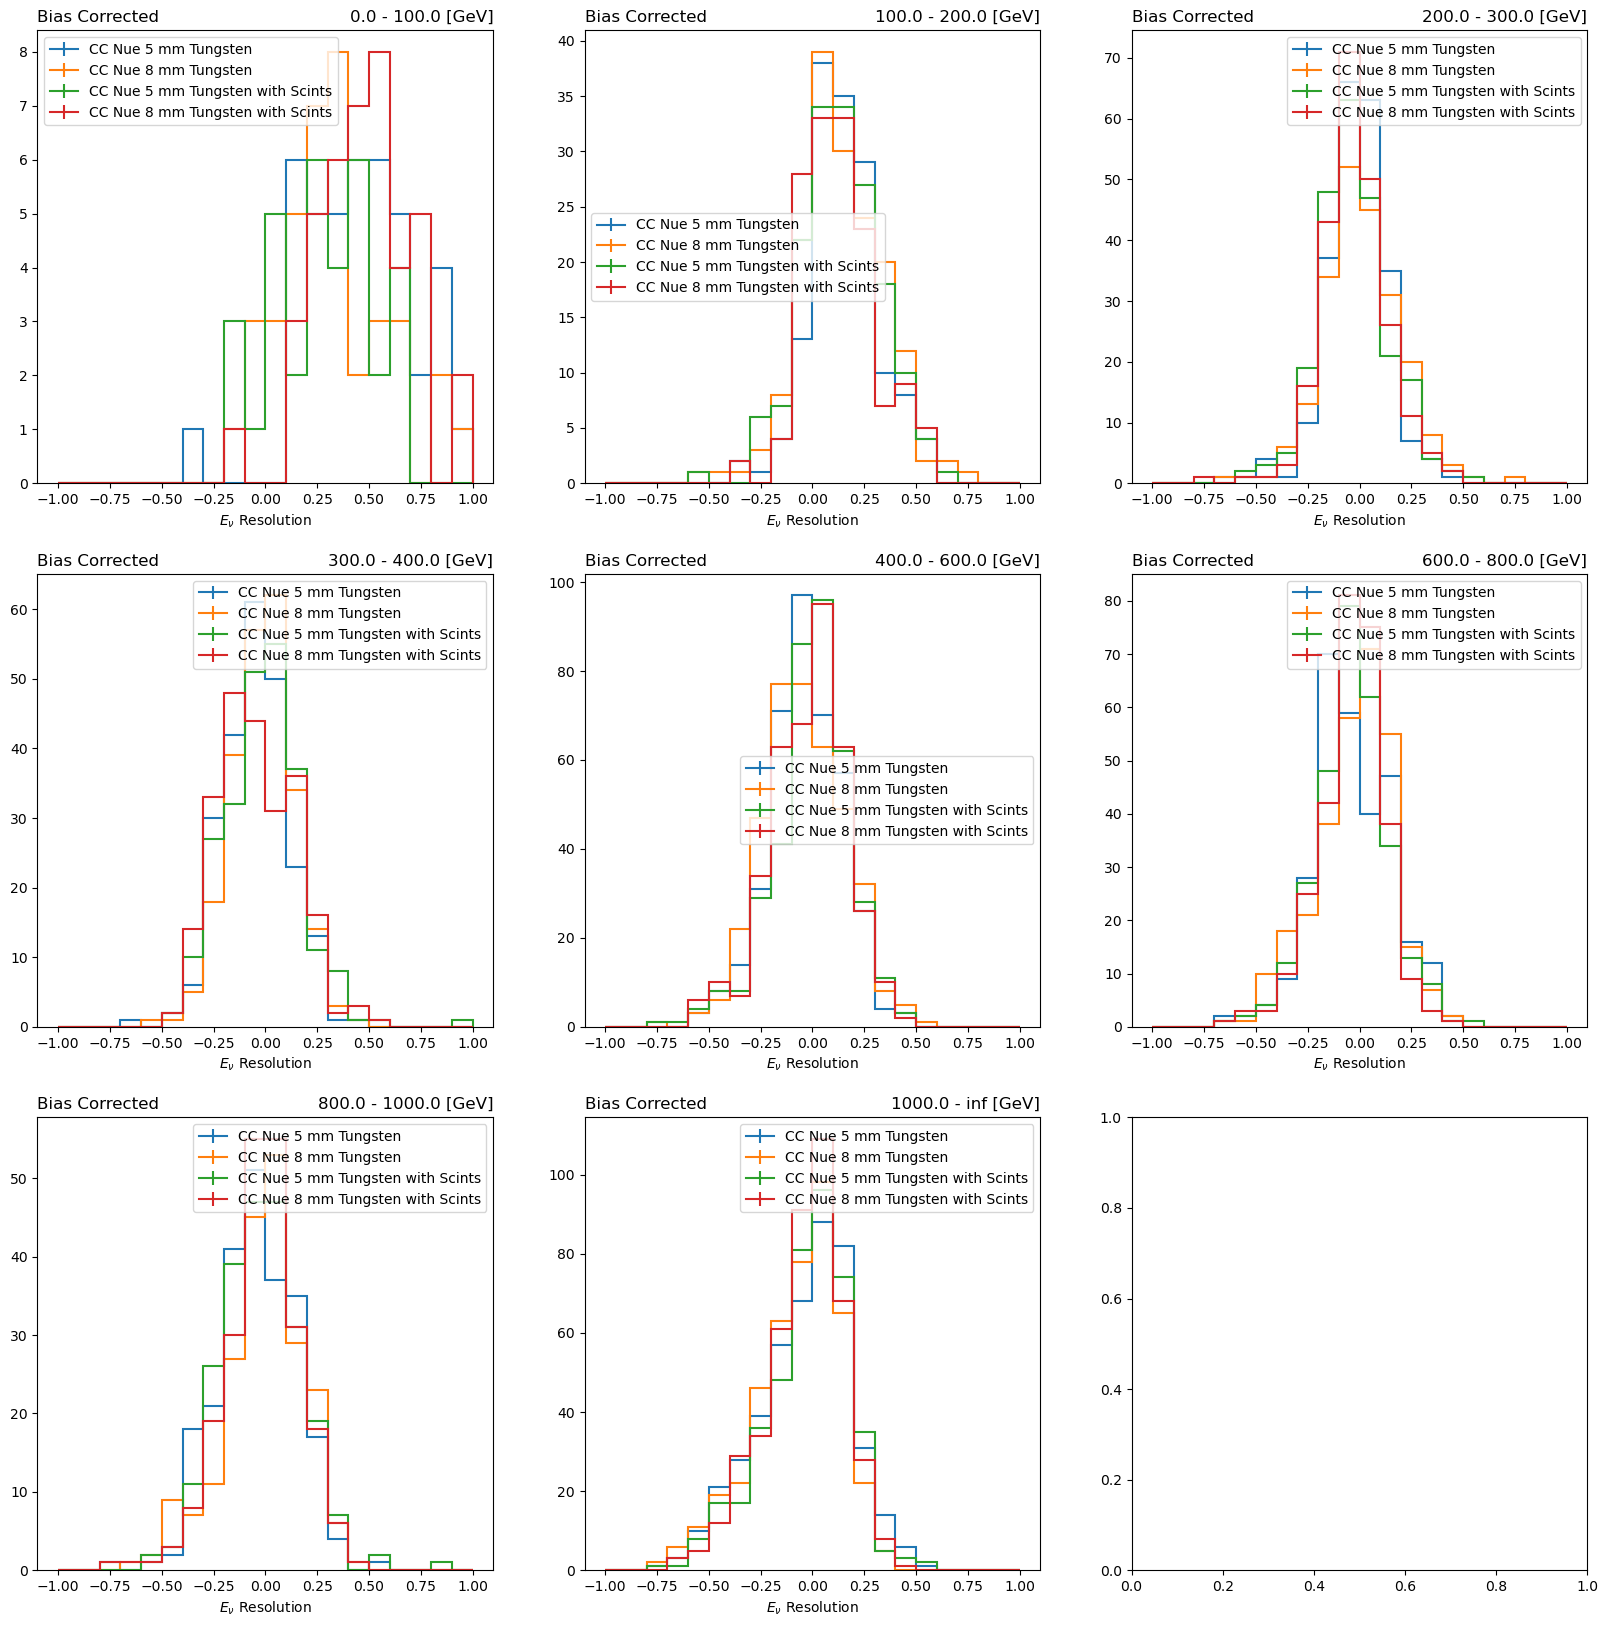

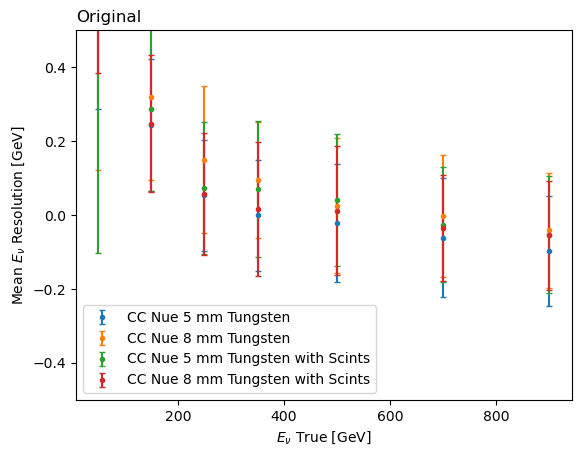

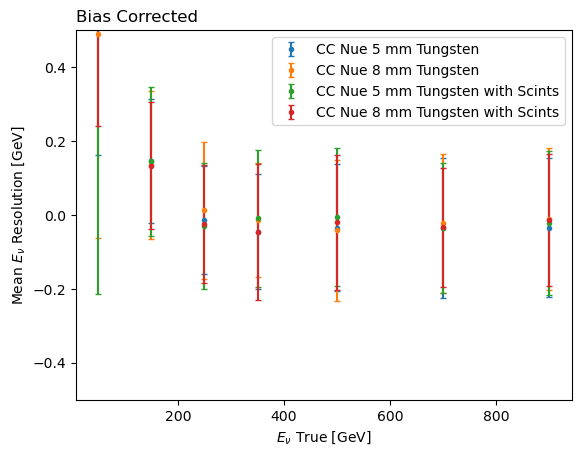

In [84]:
def plot(hists, varname, var_latex, units):
    hists_var = hists[varname]

    plot_true_v_reco(hists_var, 2, title="Original", var_latex=var_latex, unit=units)
    plot_true_v_reco(hists_var, 3, title="Bias Corrected", var_latex=var_latex, unit=units)

    plot_res_hists(hists_var, 0, title="Original", var_latex=var_latex, unit=units)
    plot_res_hists(hists_var, 1, title="Bias Corrected", var_latex=var_latex, unit=units)

    plot_stats(hists_var, 4, title="Original", var_latex=var_latex, unit=units)
    plot_stats(hists_var, 5, title="Bias Corrected", var_latex=var_latex, unit=units)

    

plot(hists, "E_nu", r"E_\nu", "[GeV]")

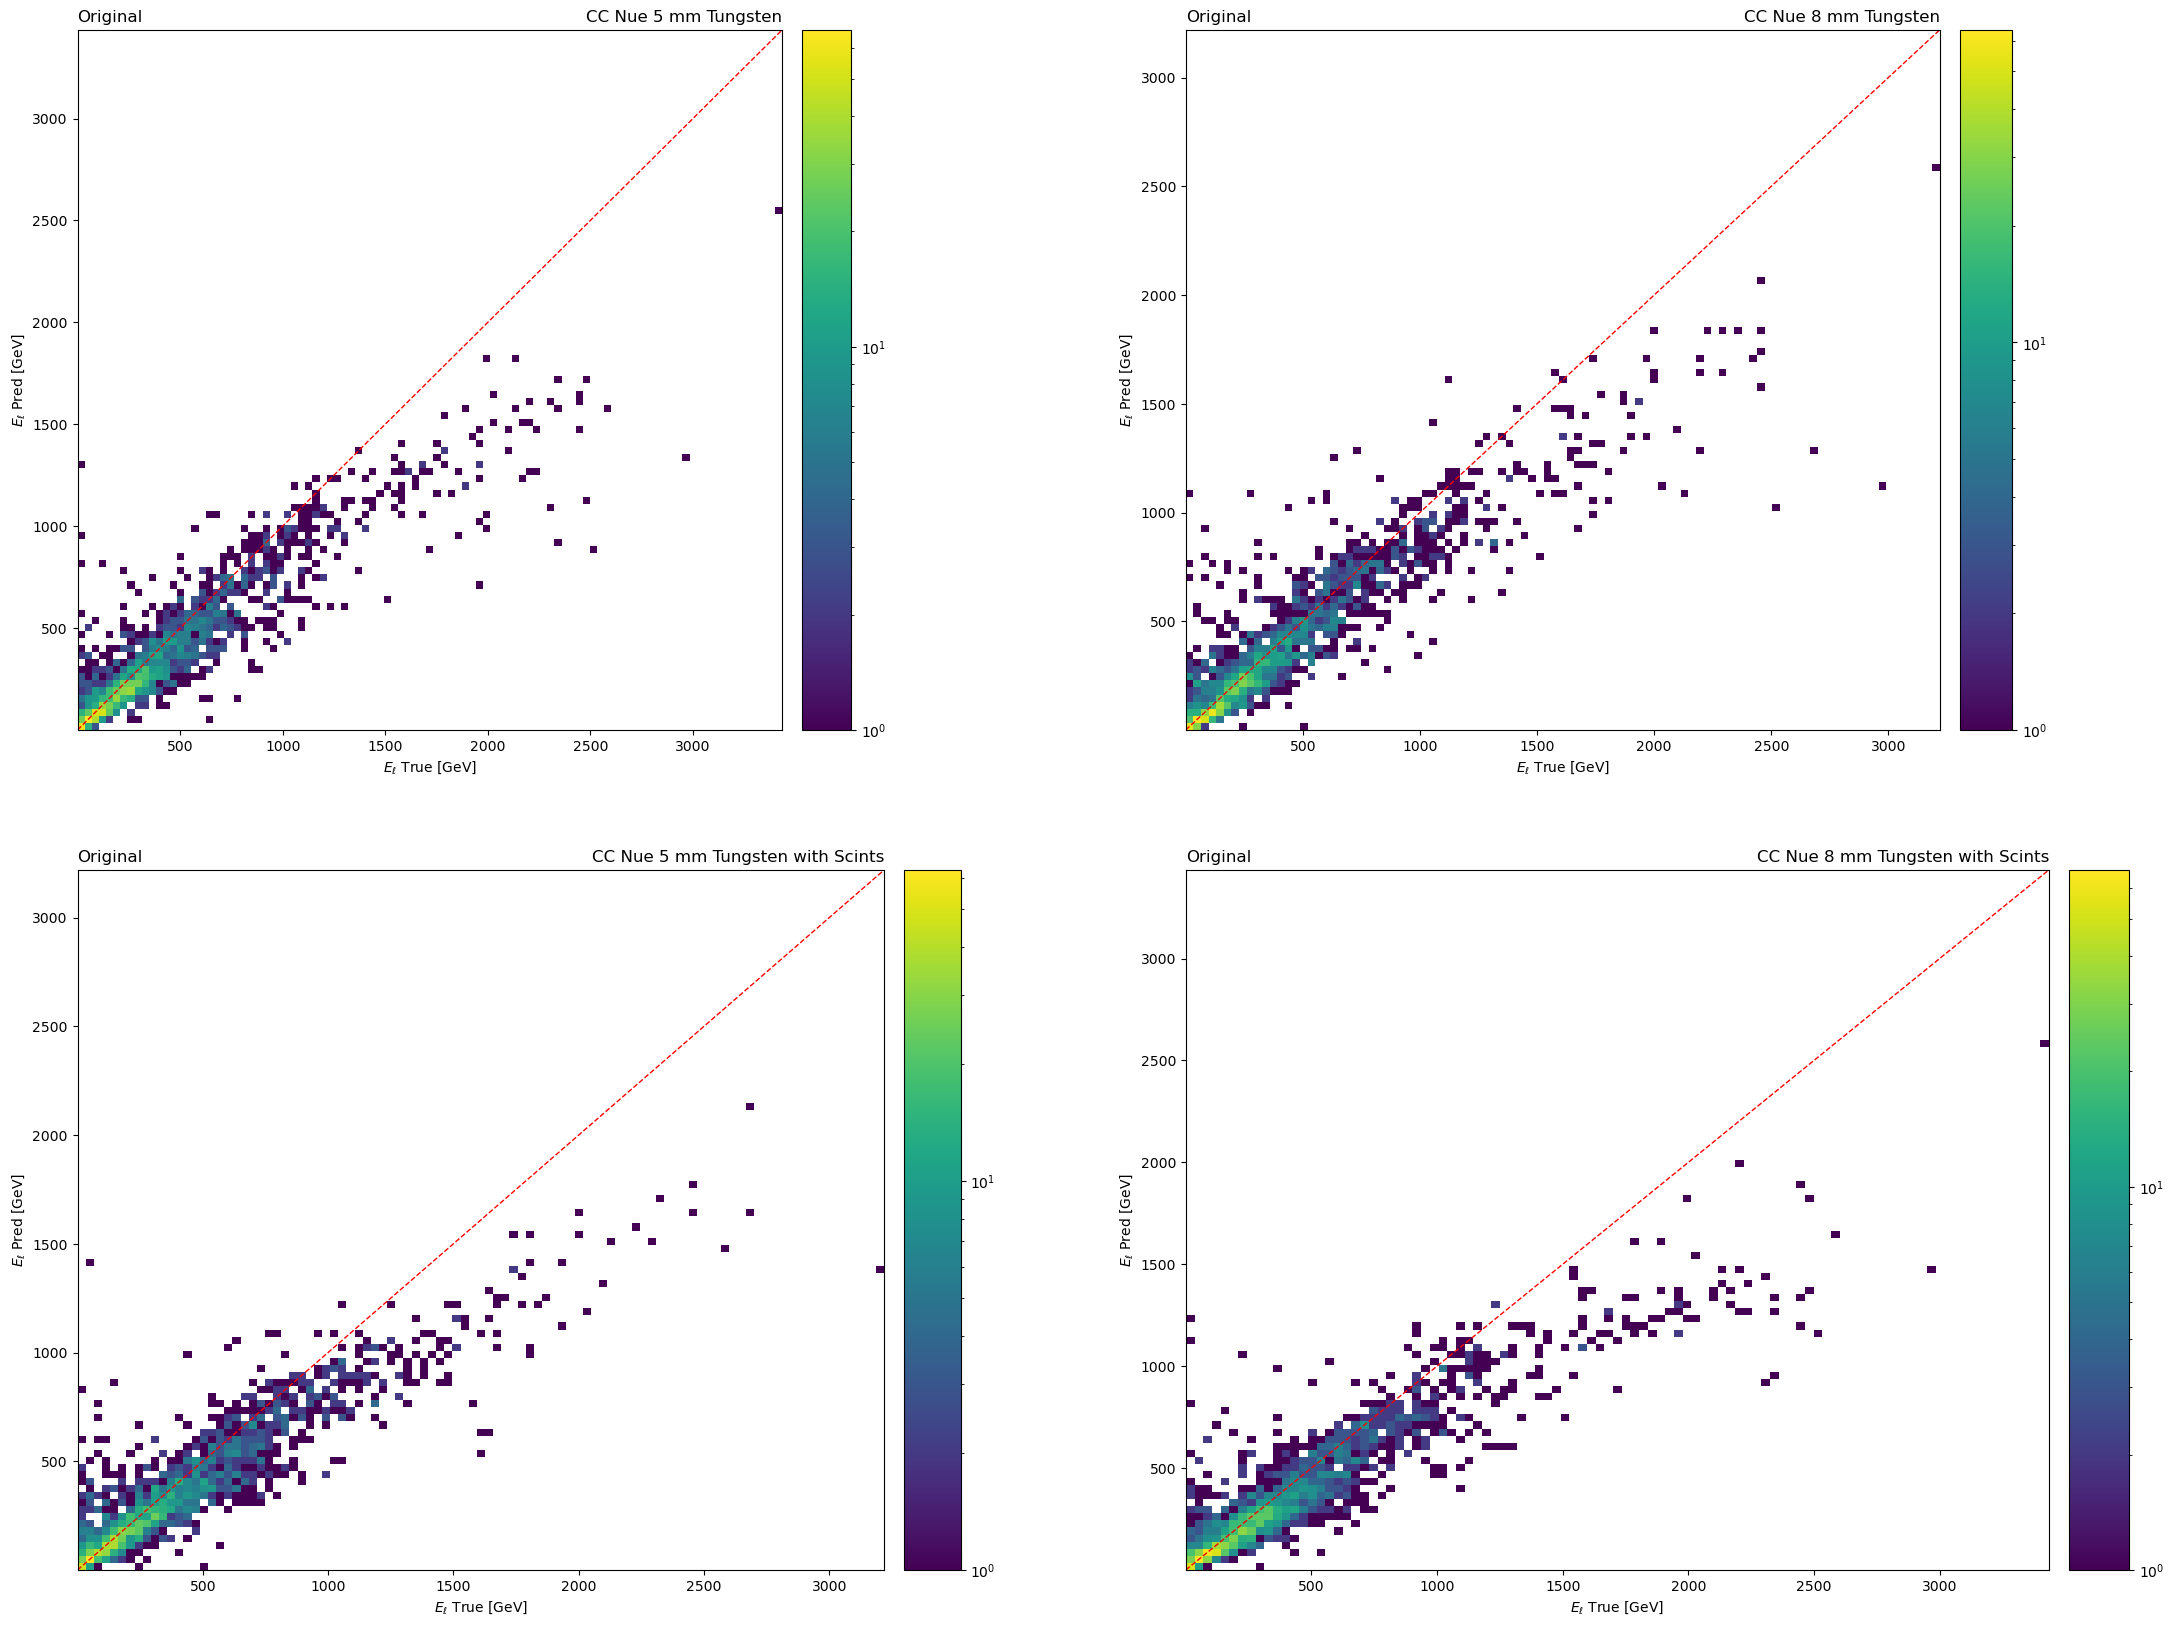

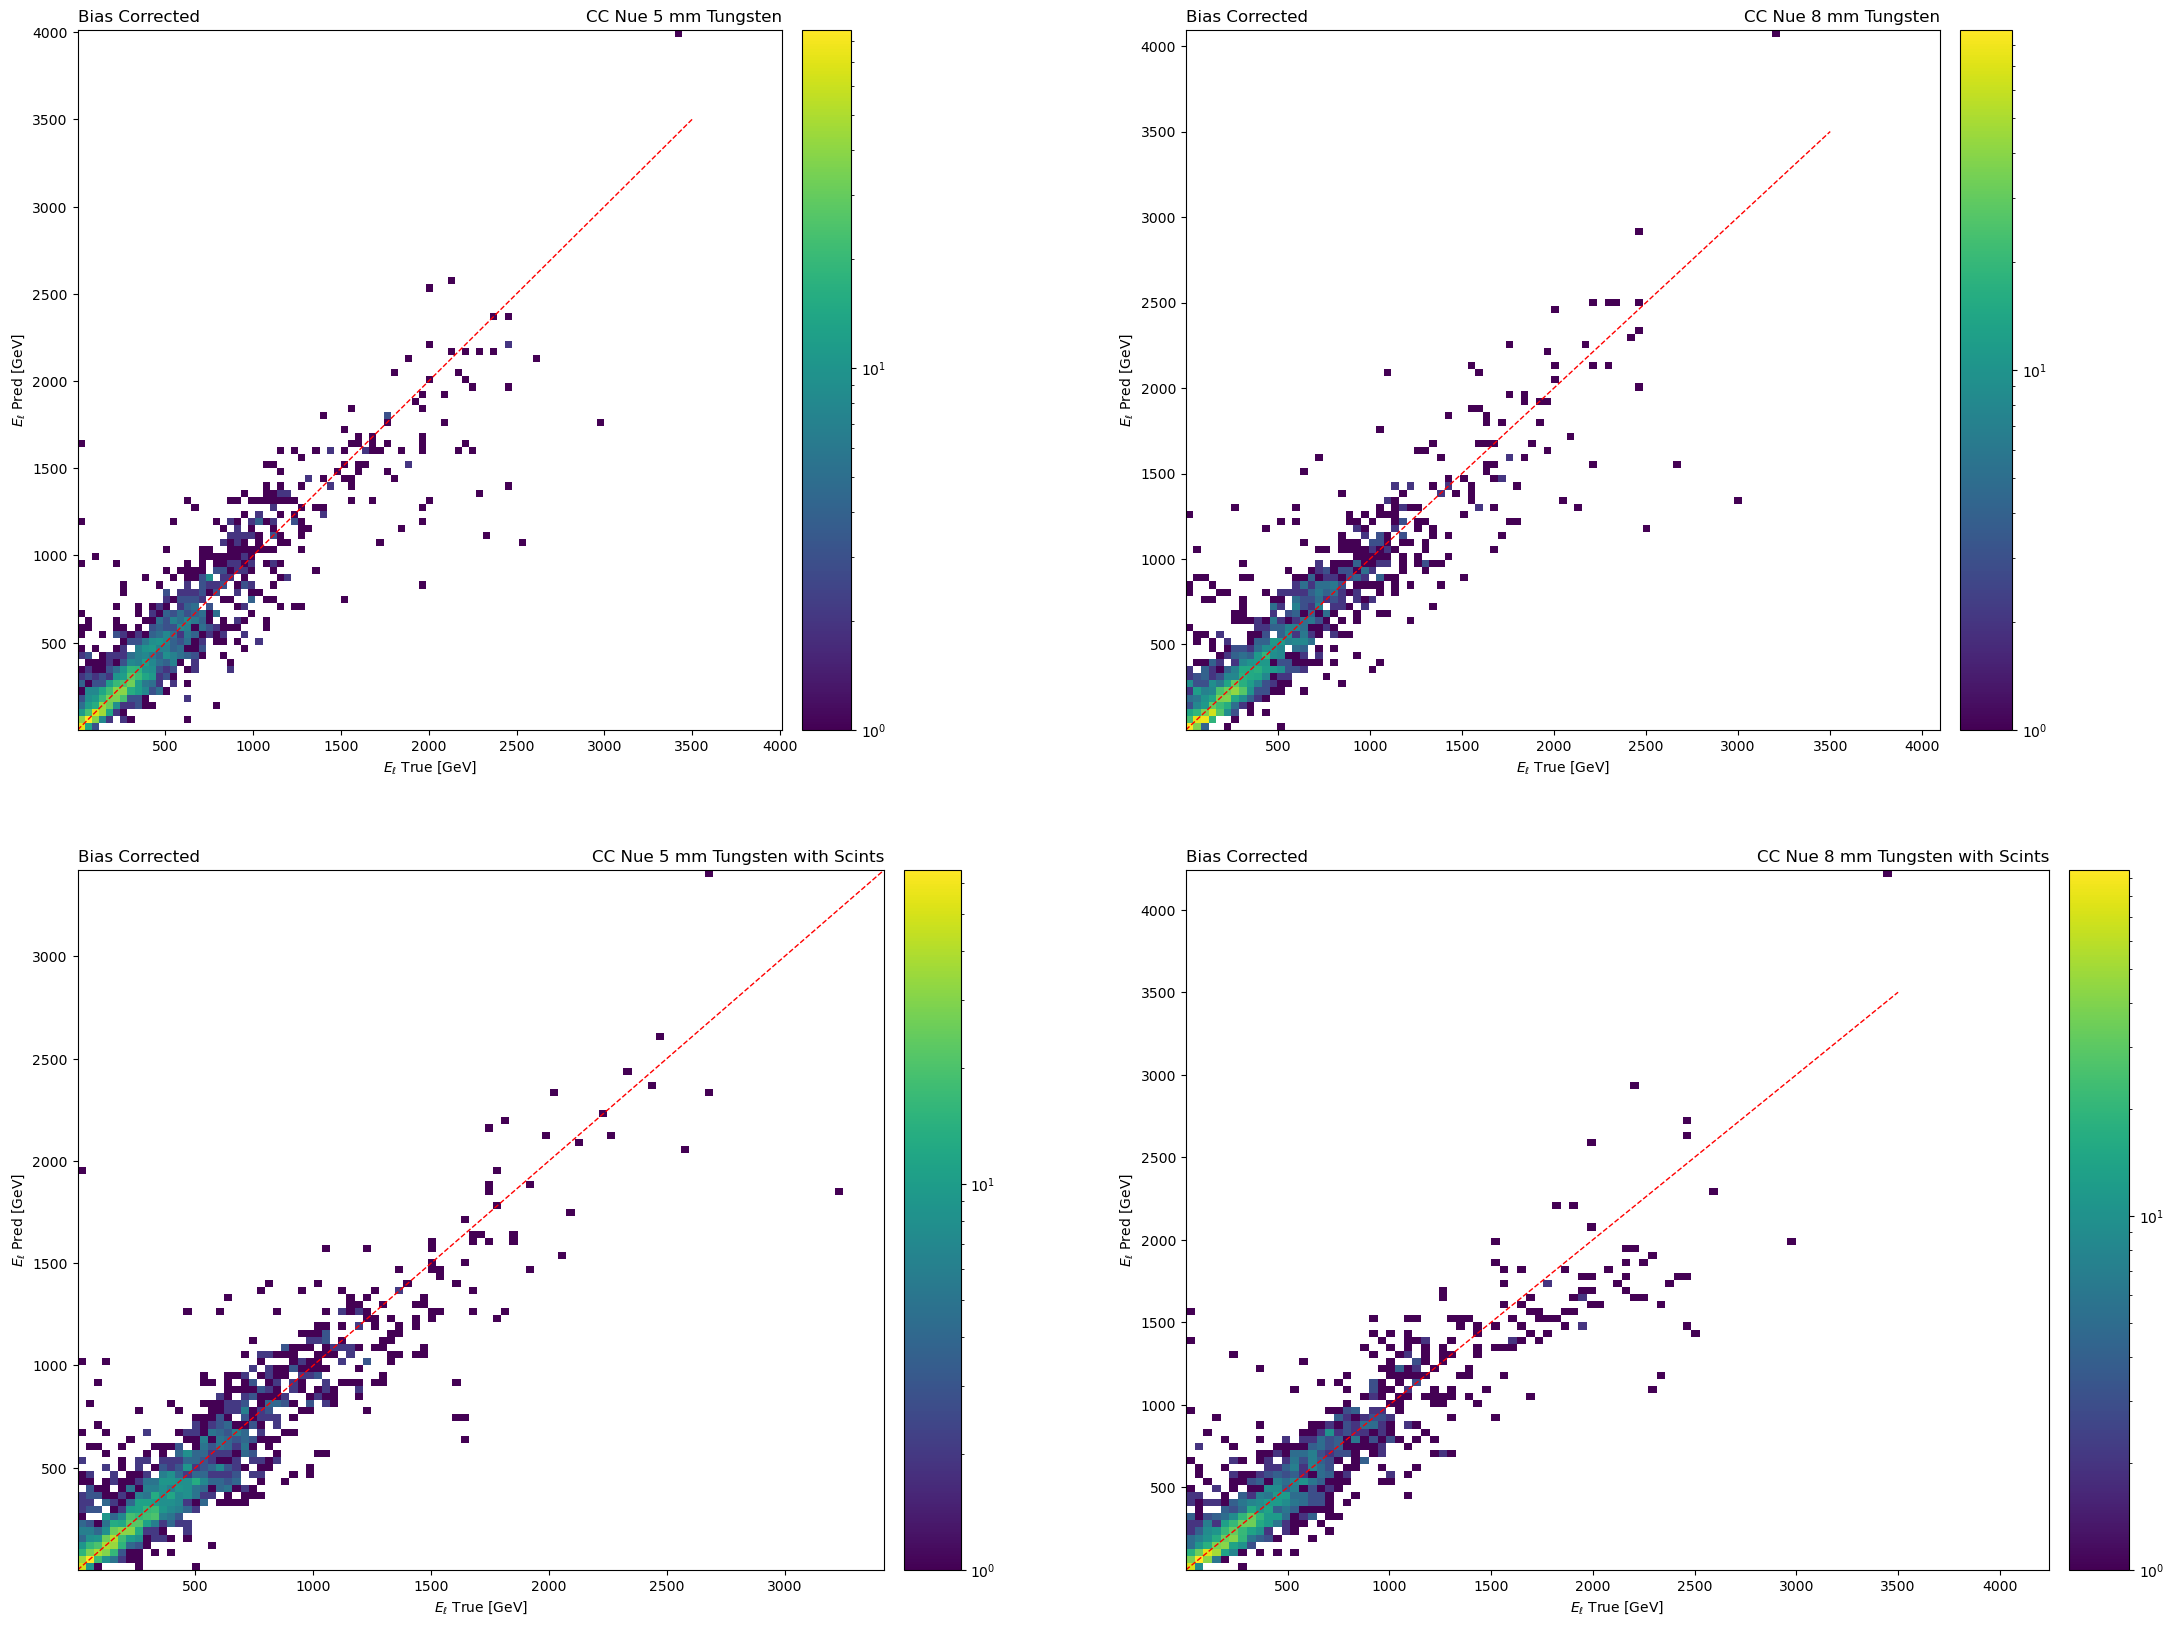

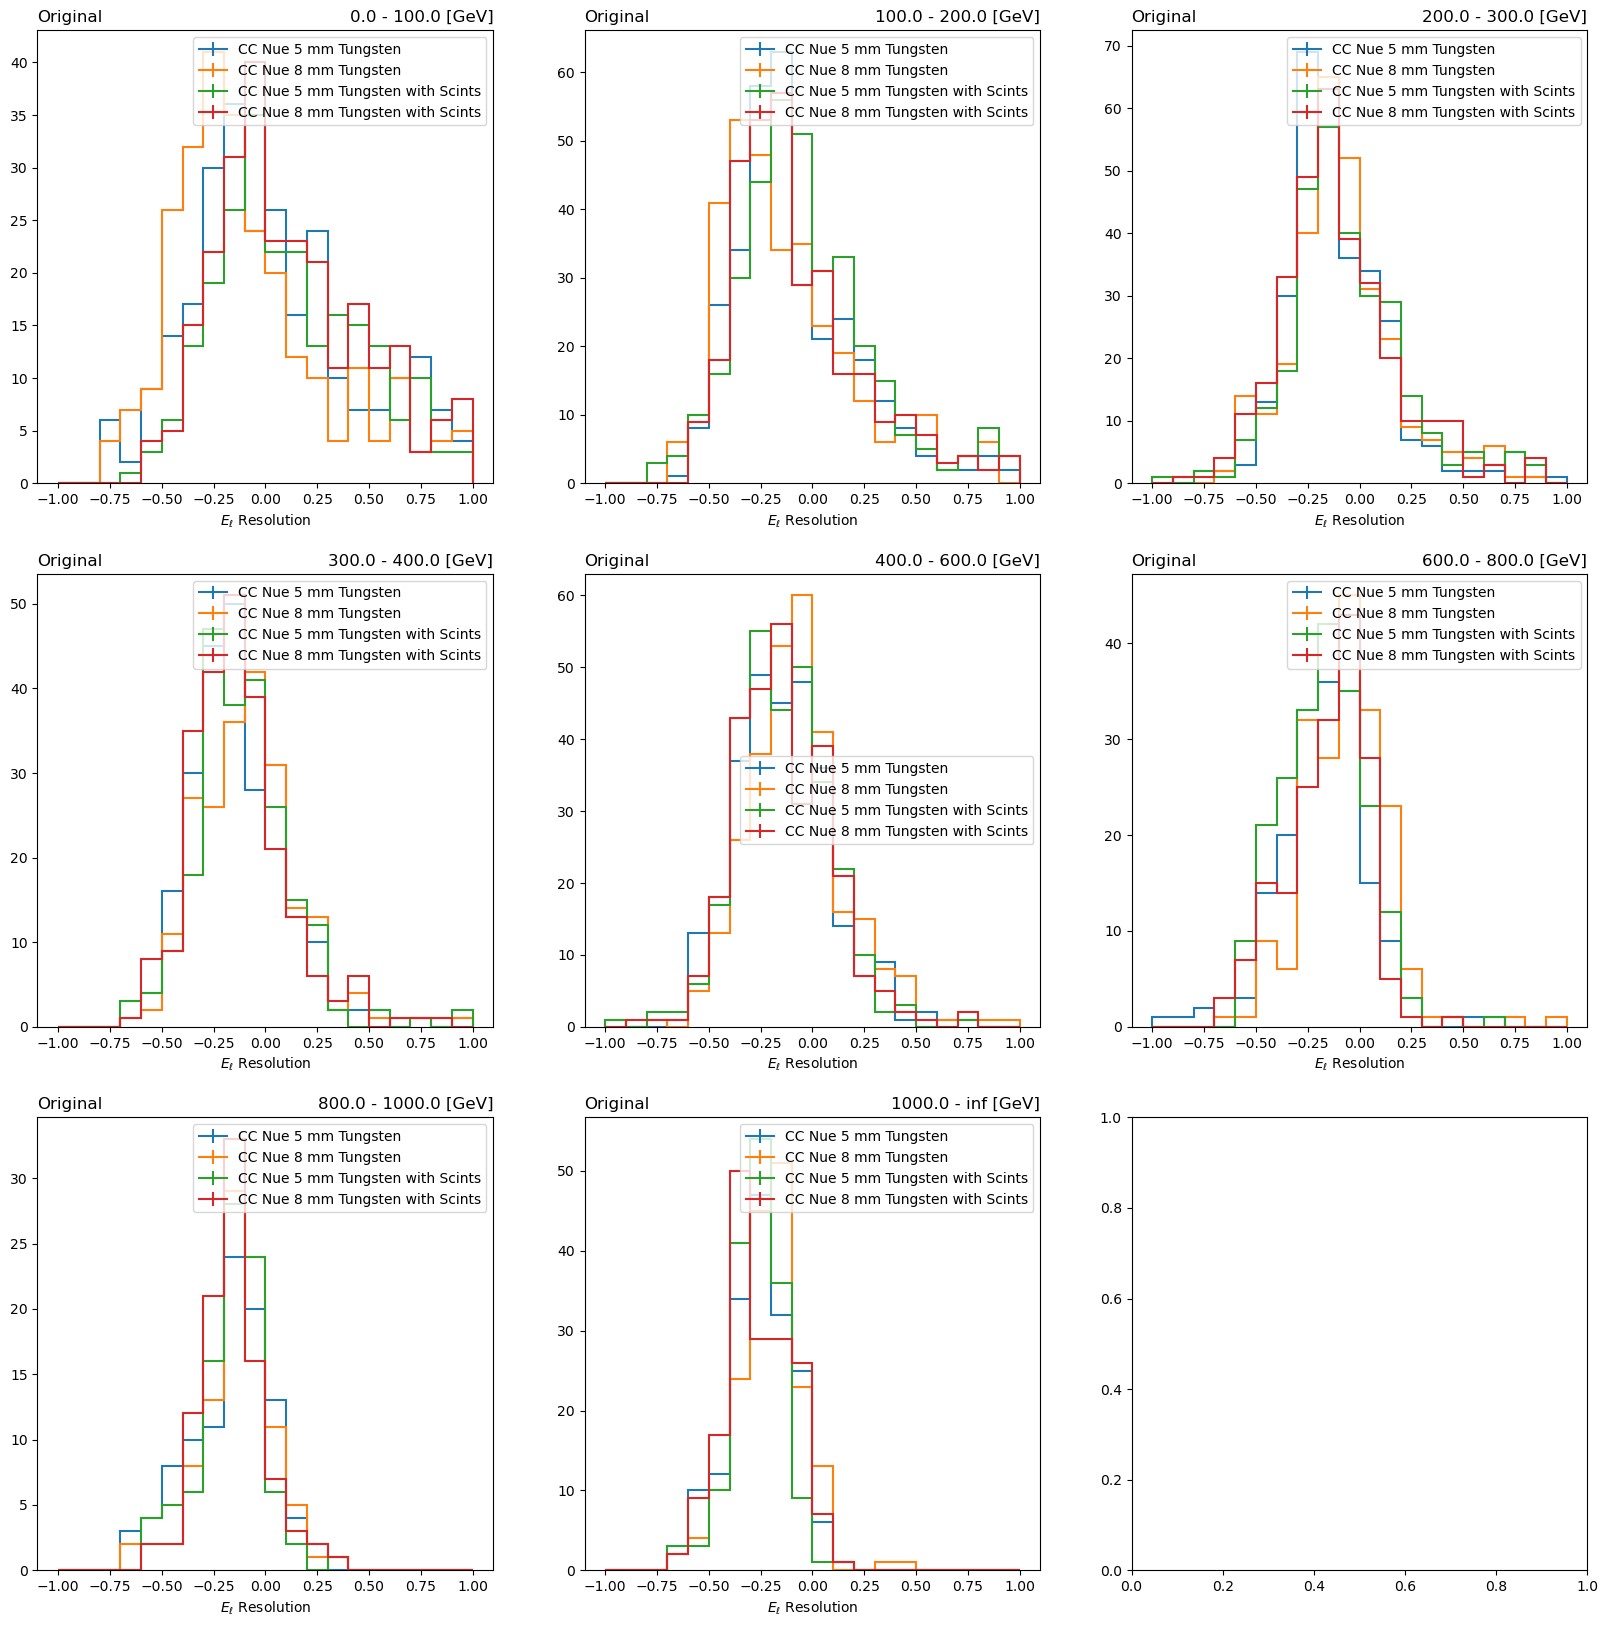

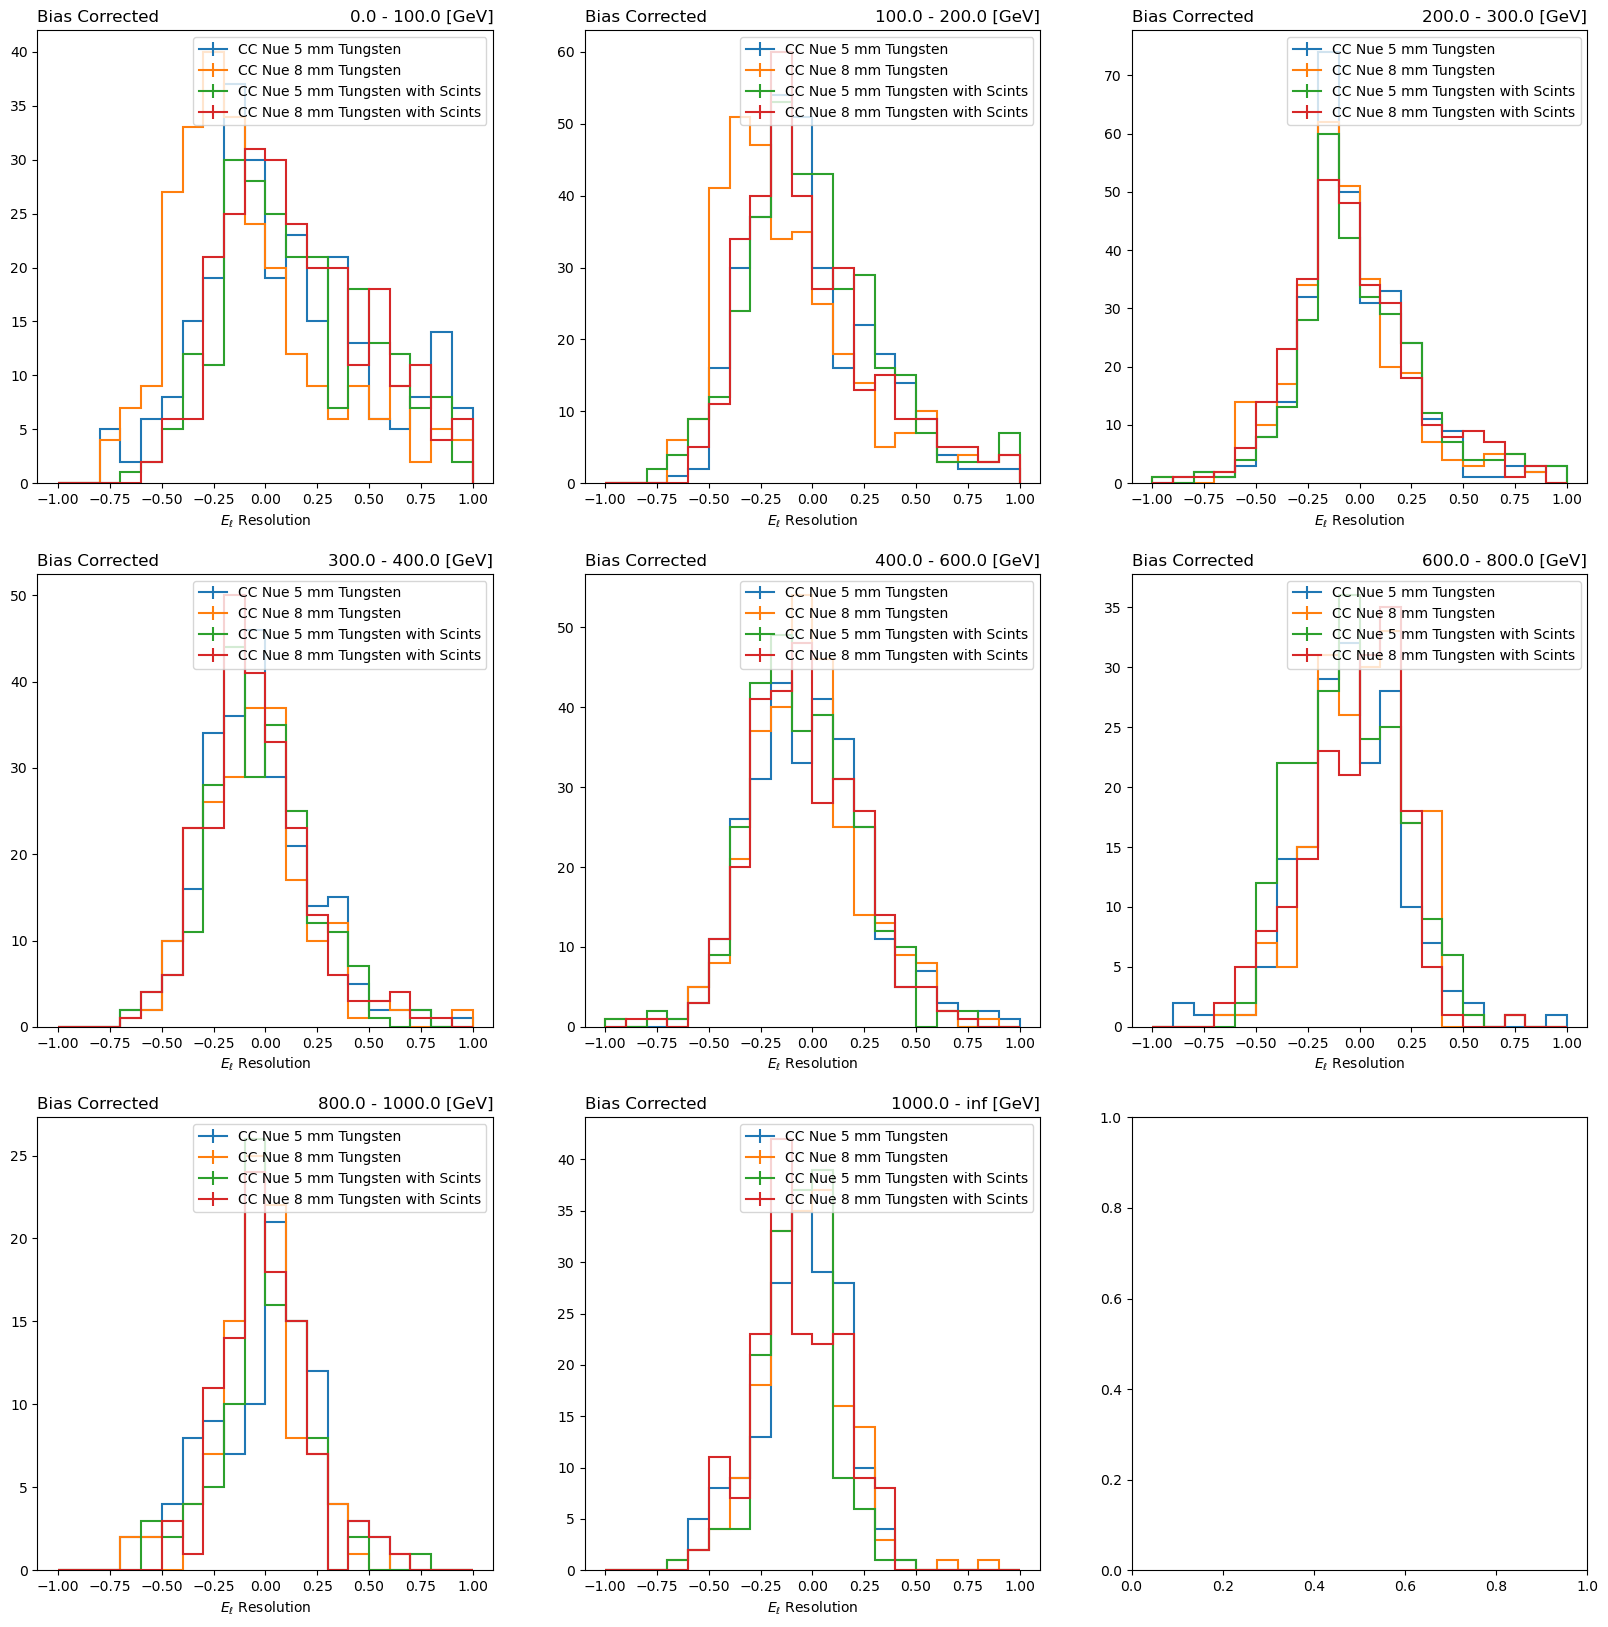

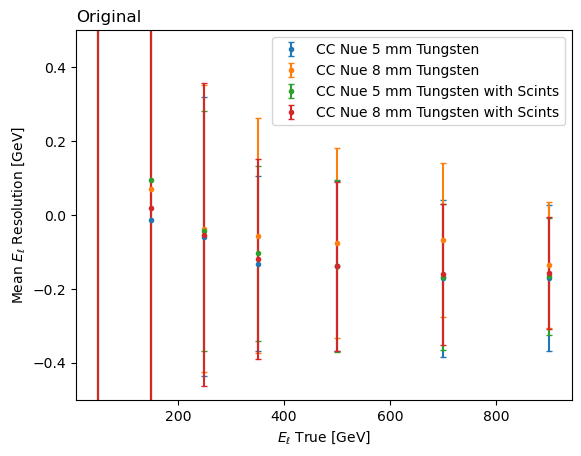

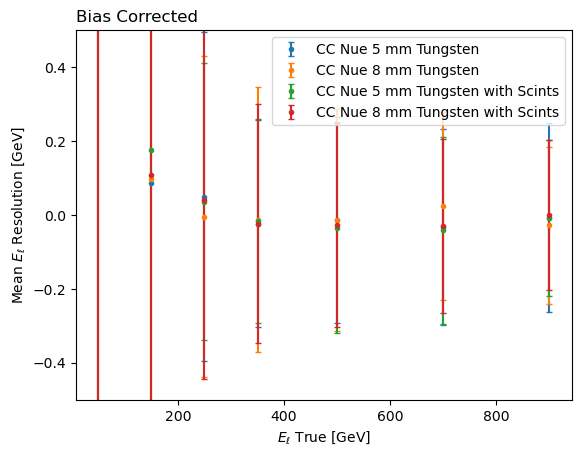

In [85]:
plot(hists, "E_lep", r"E_\ell", "[GeV]")

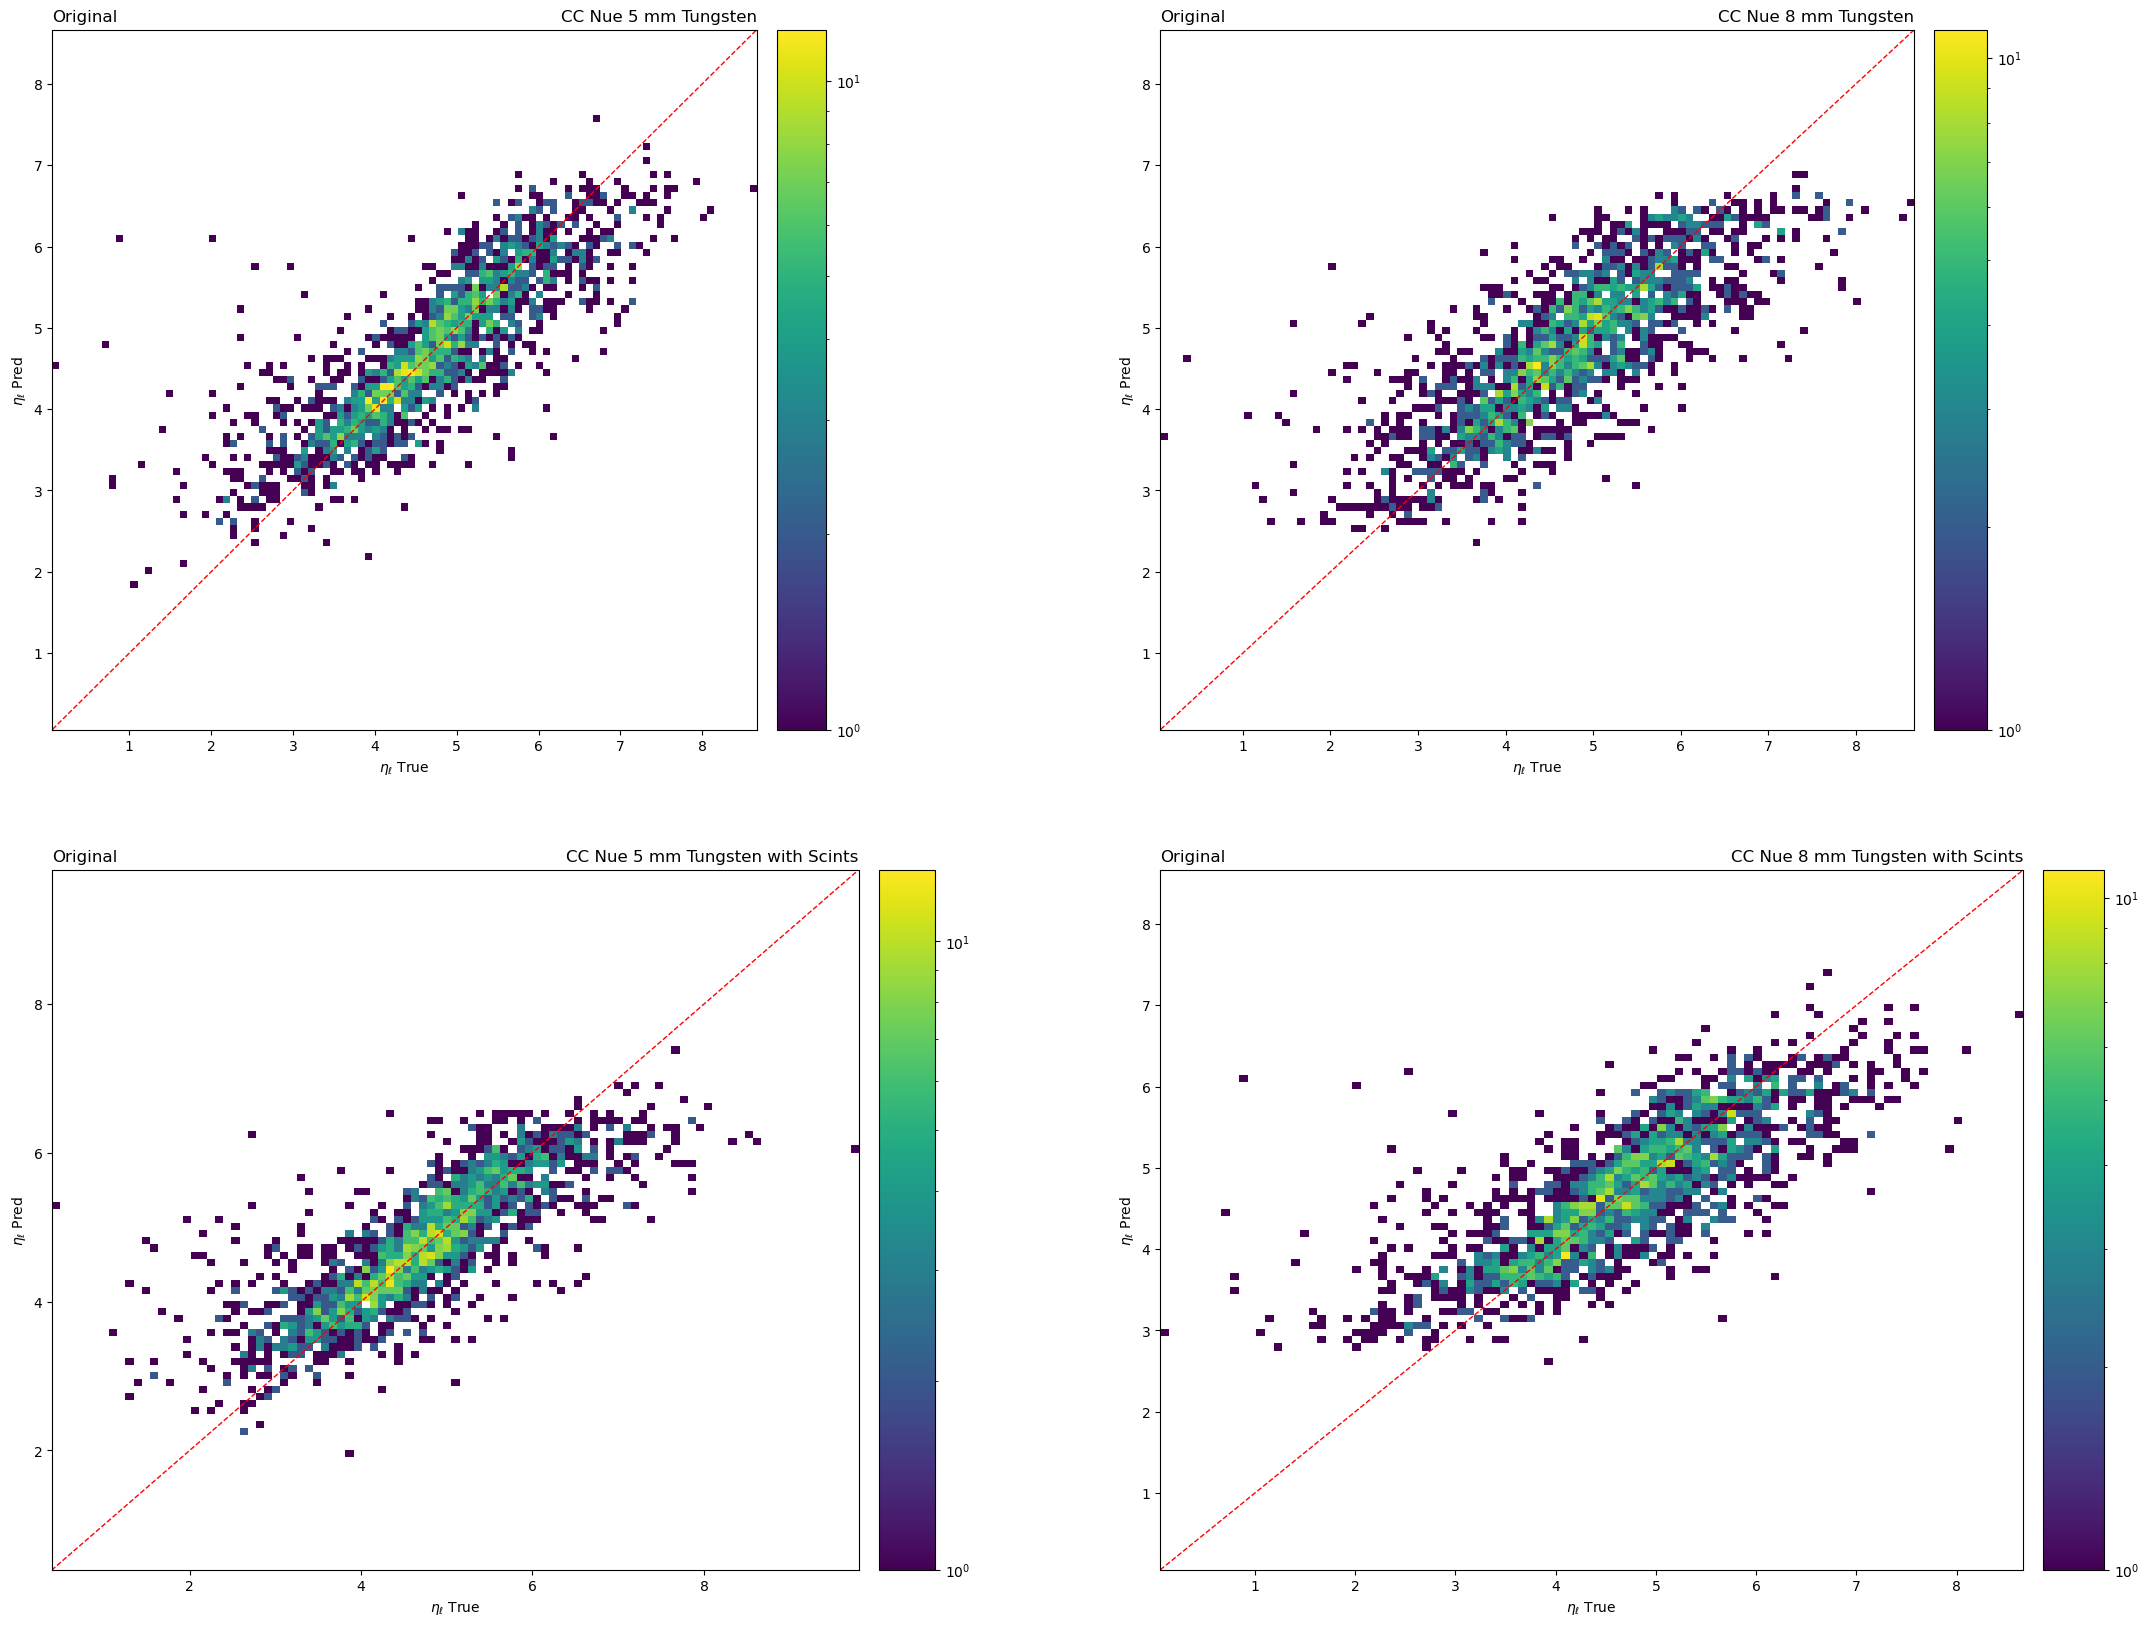

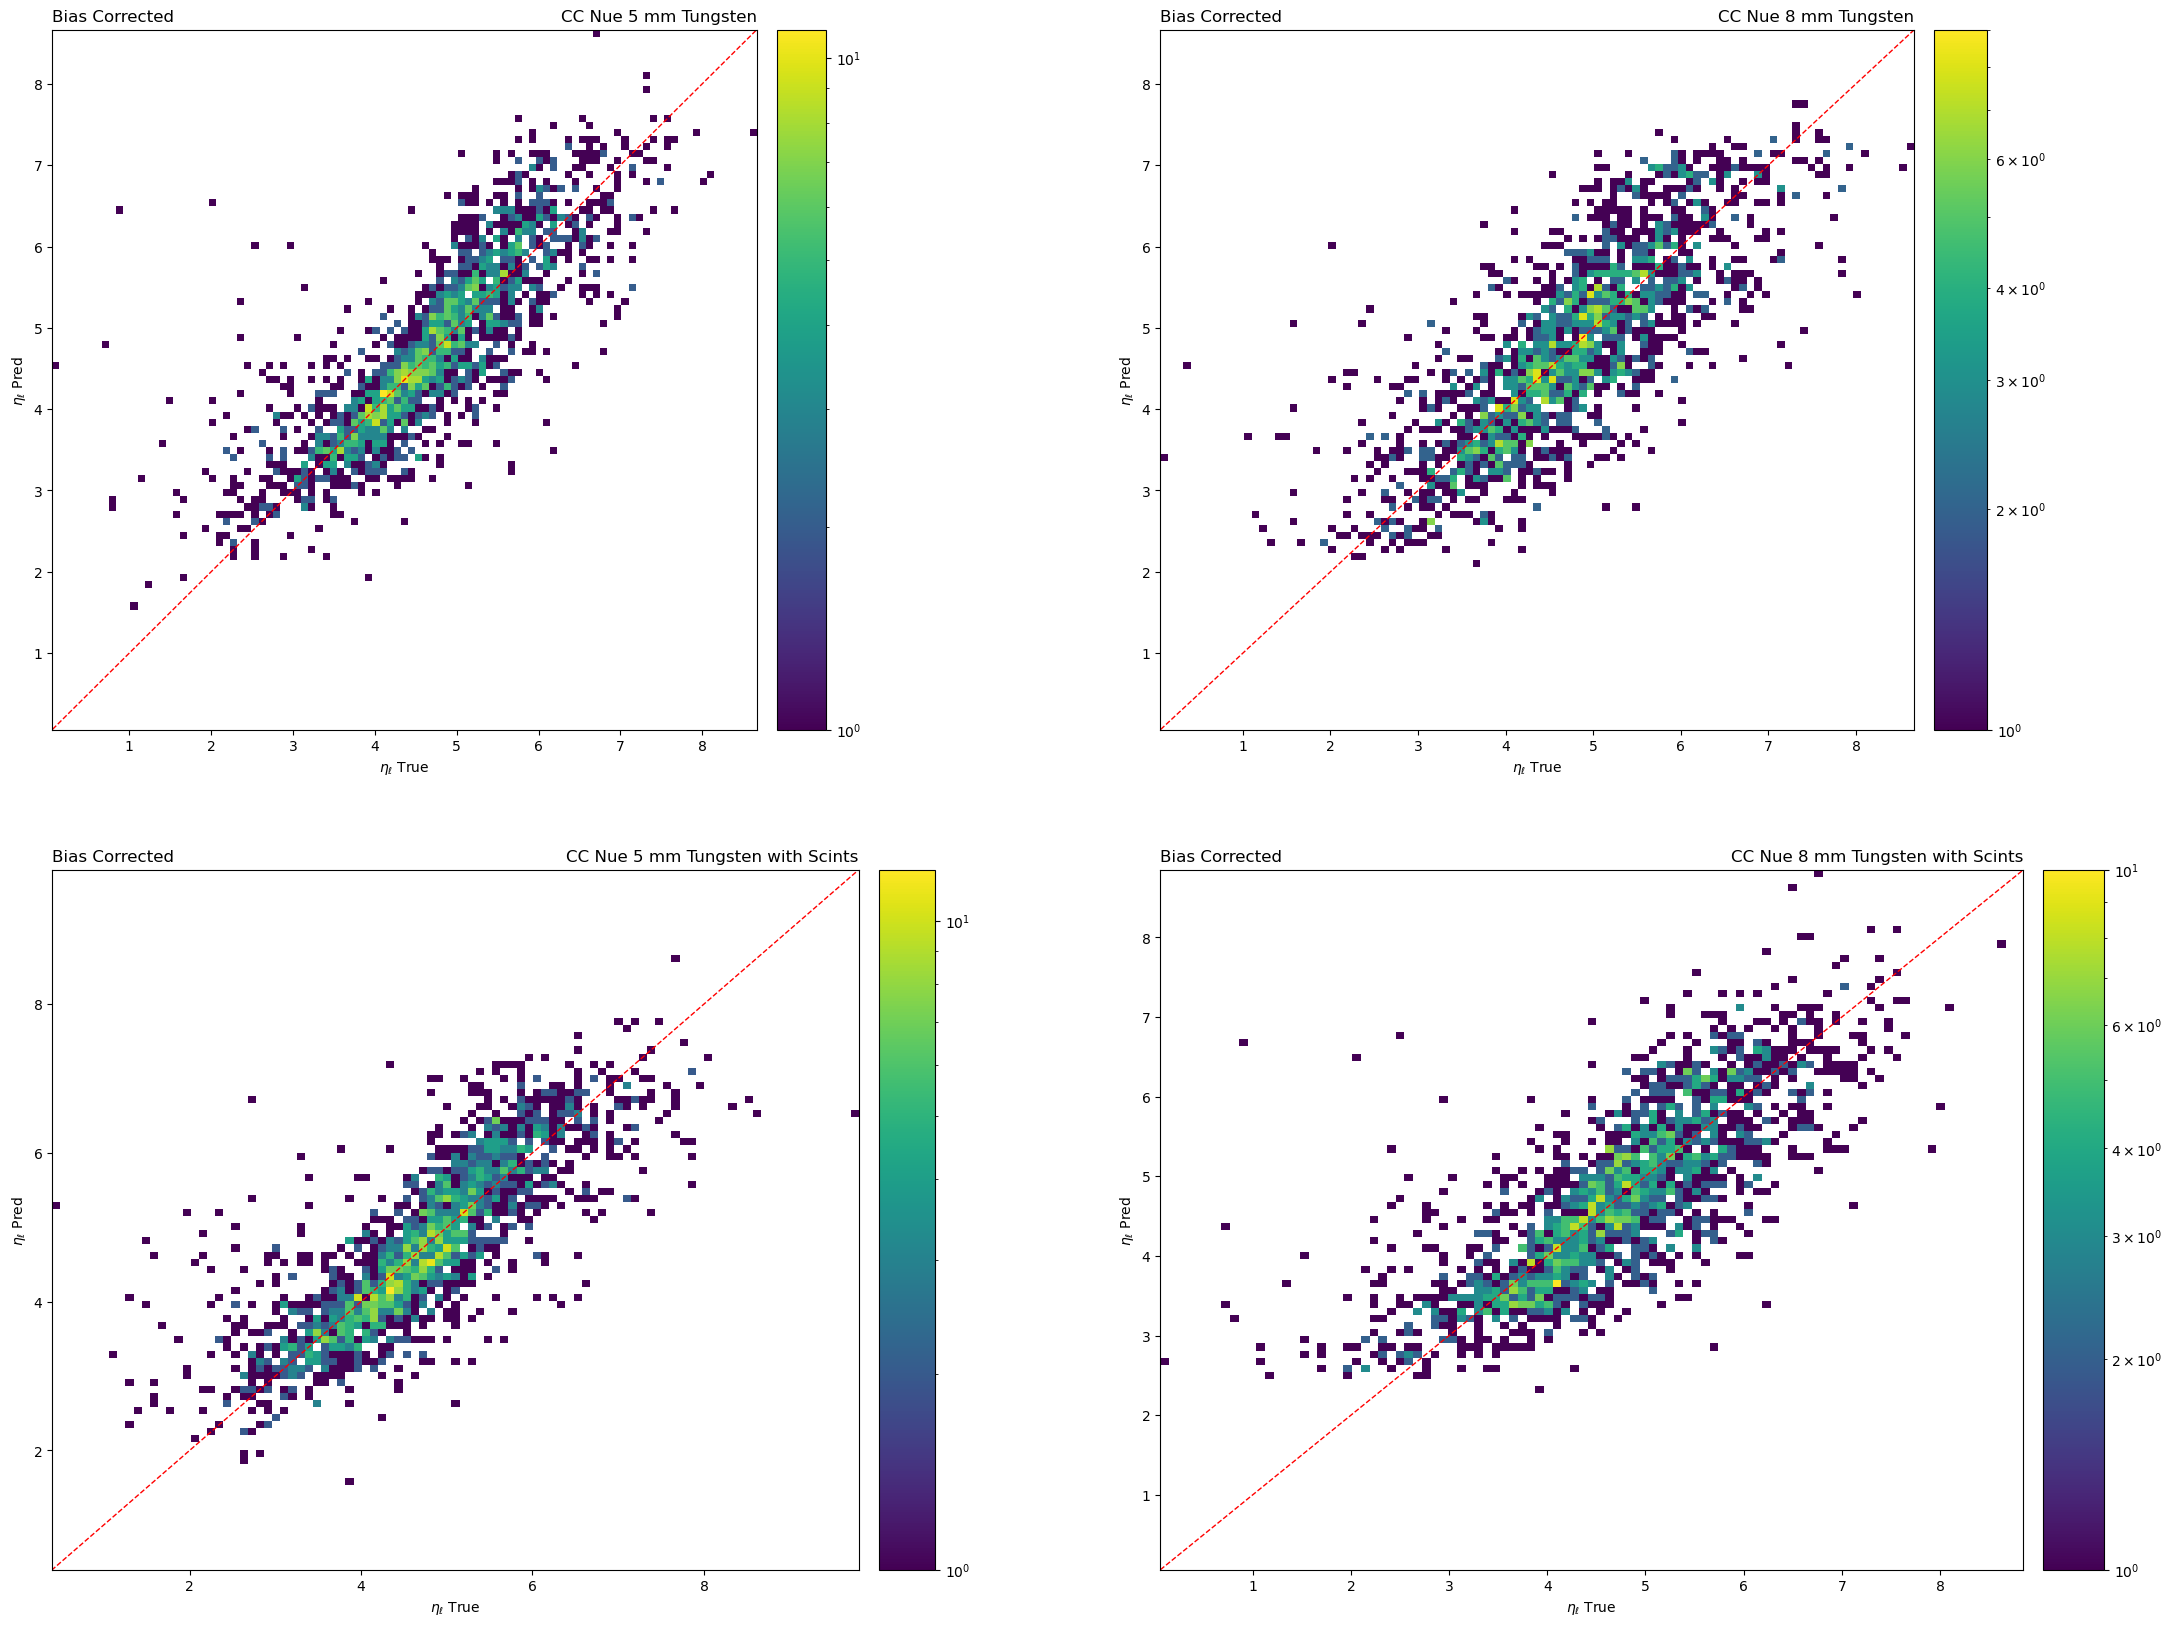

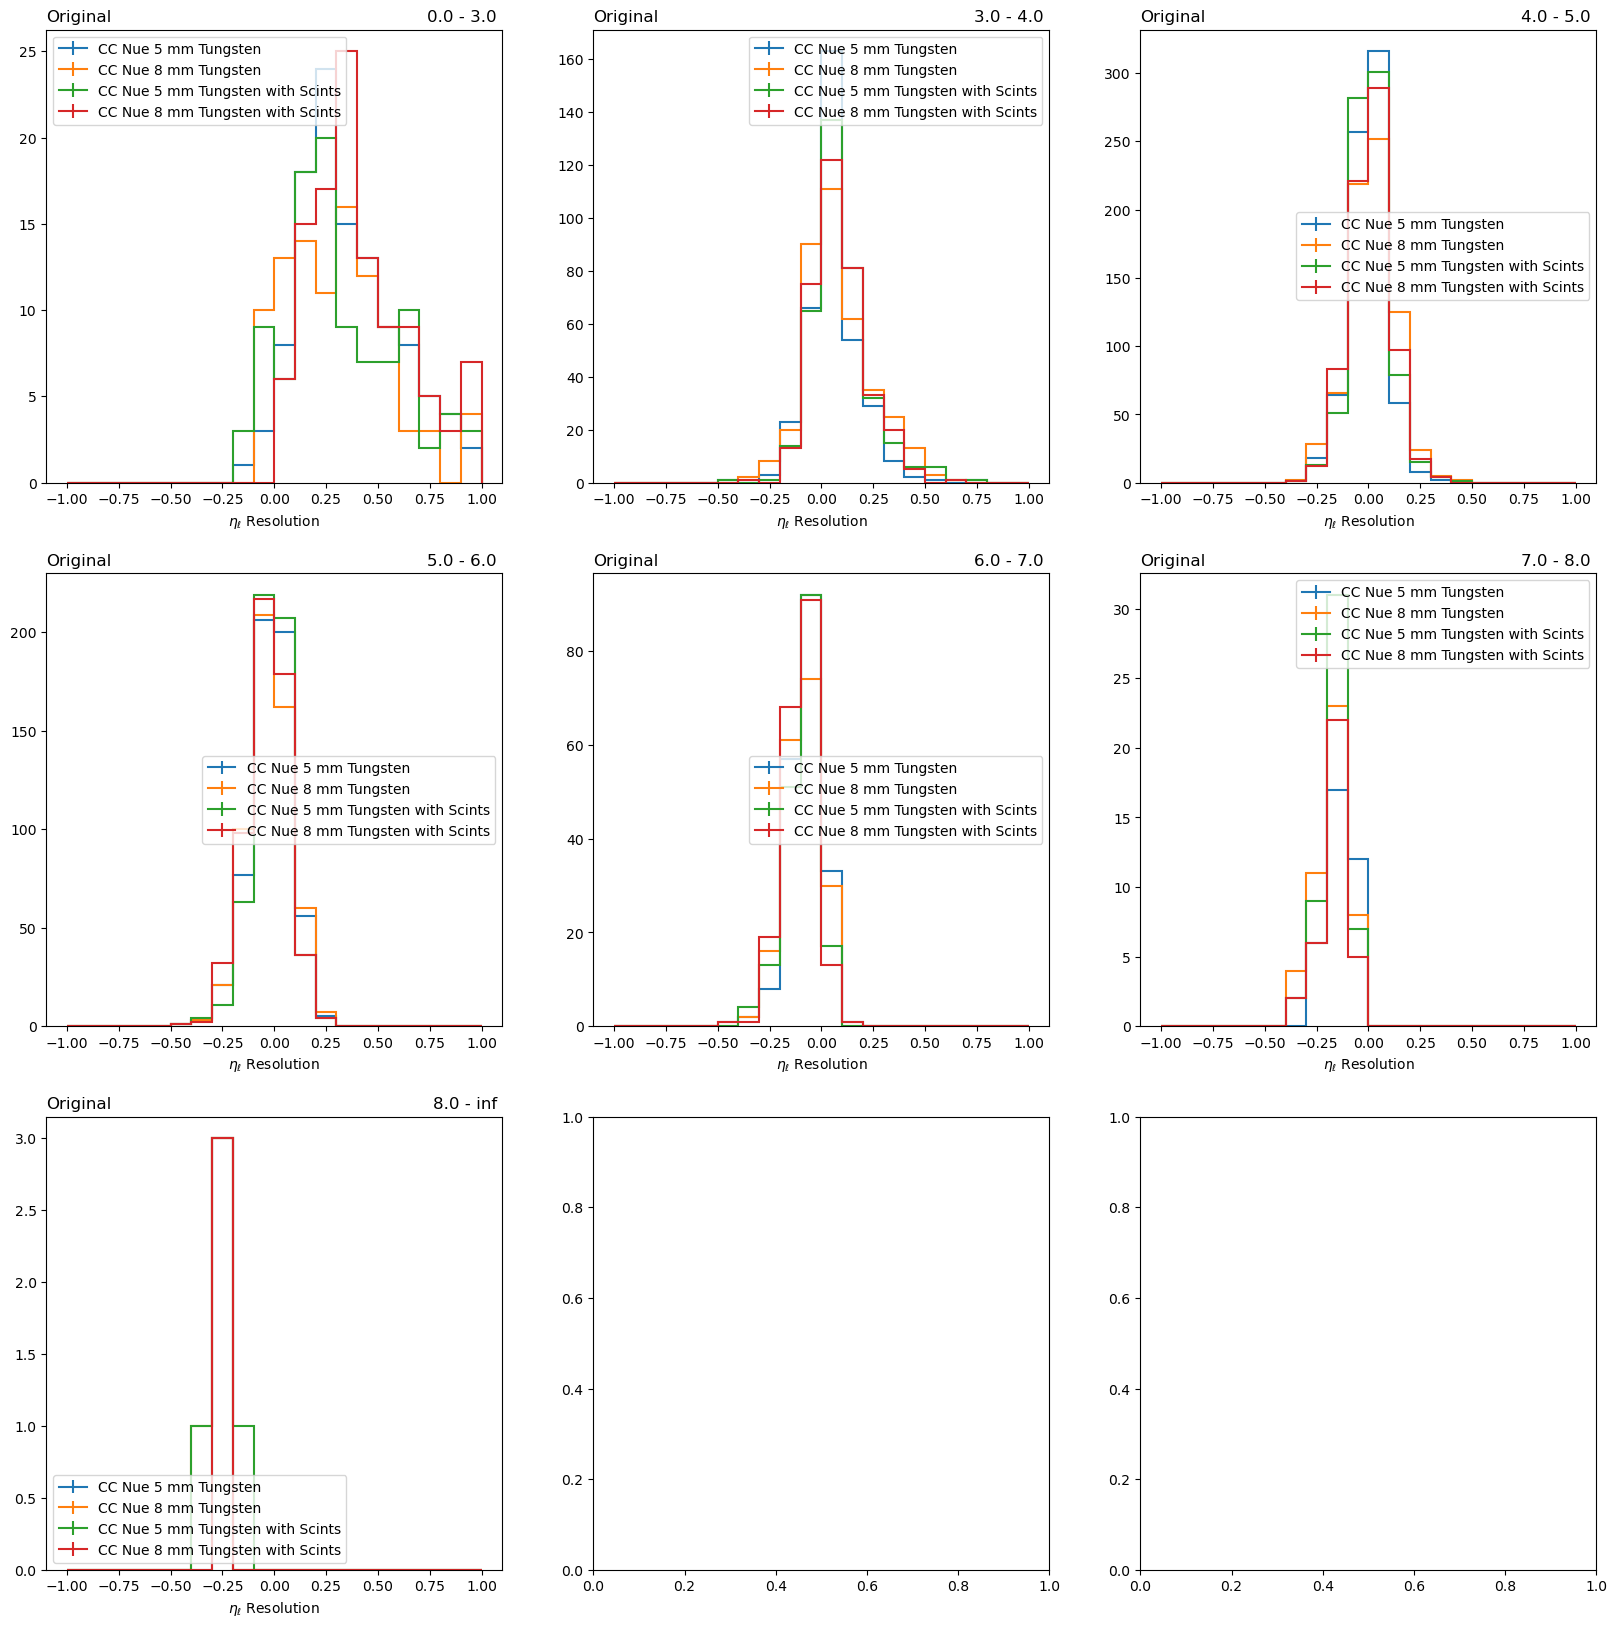

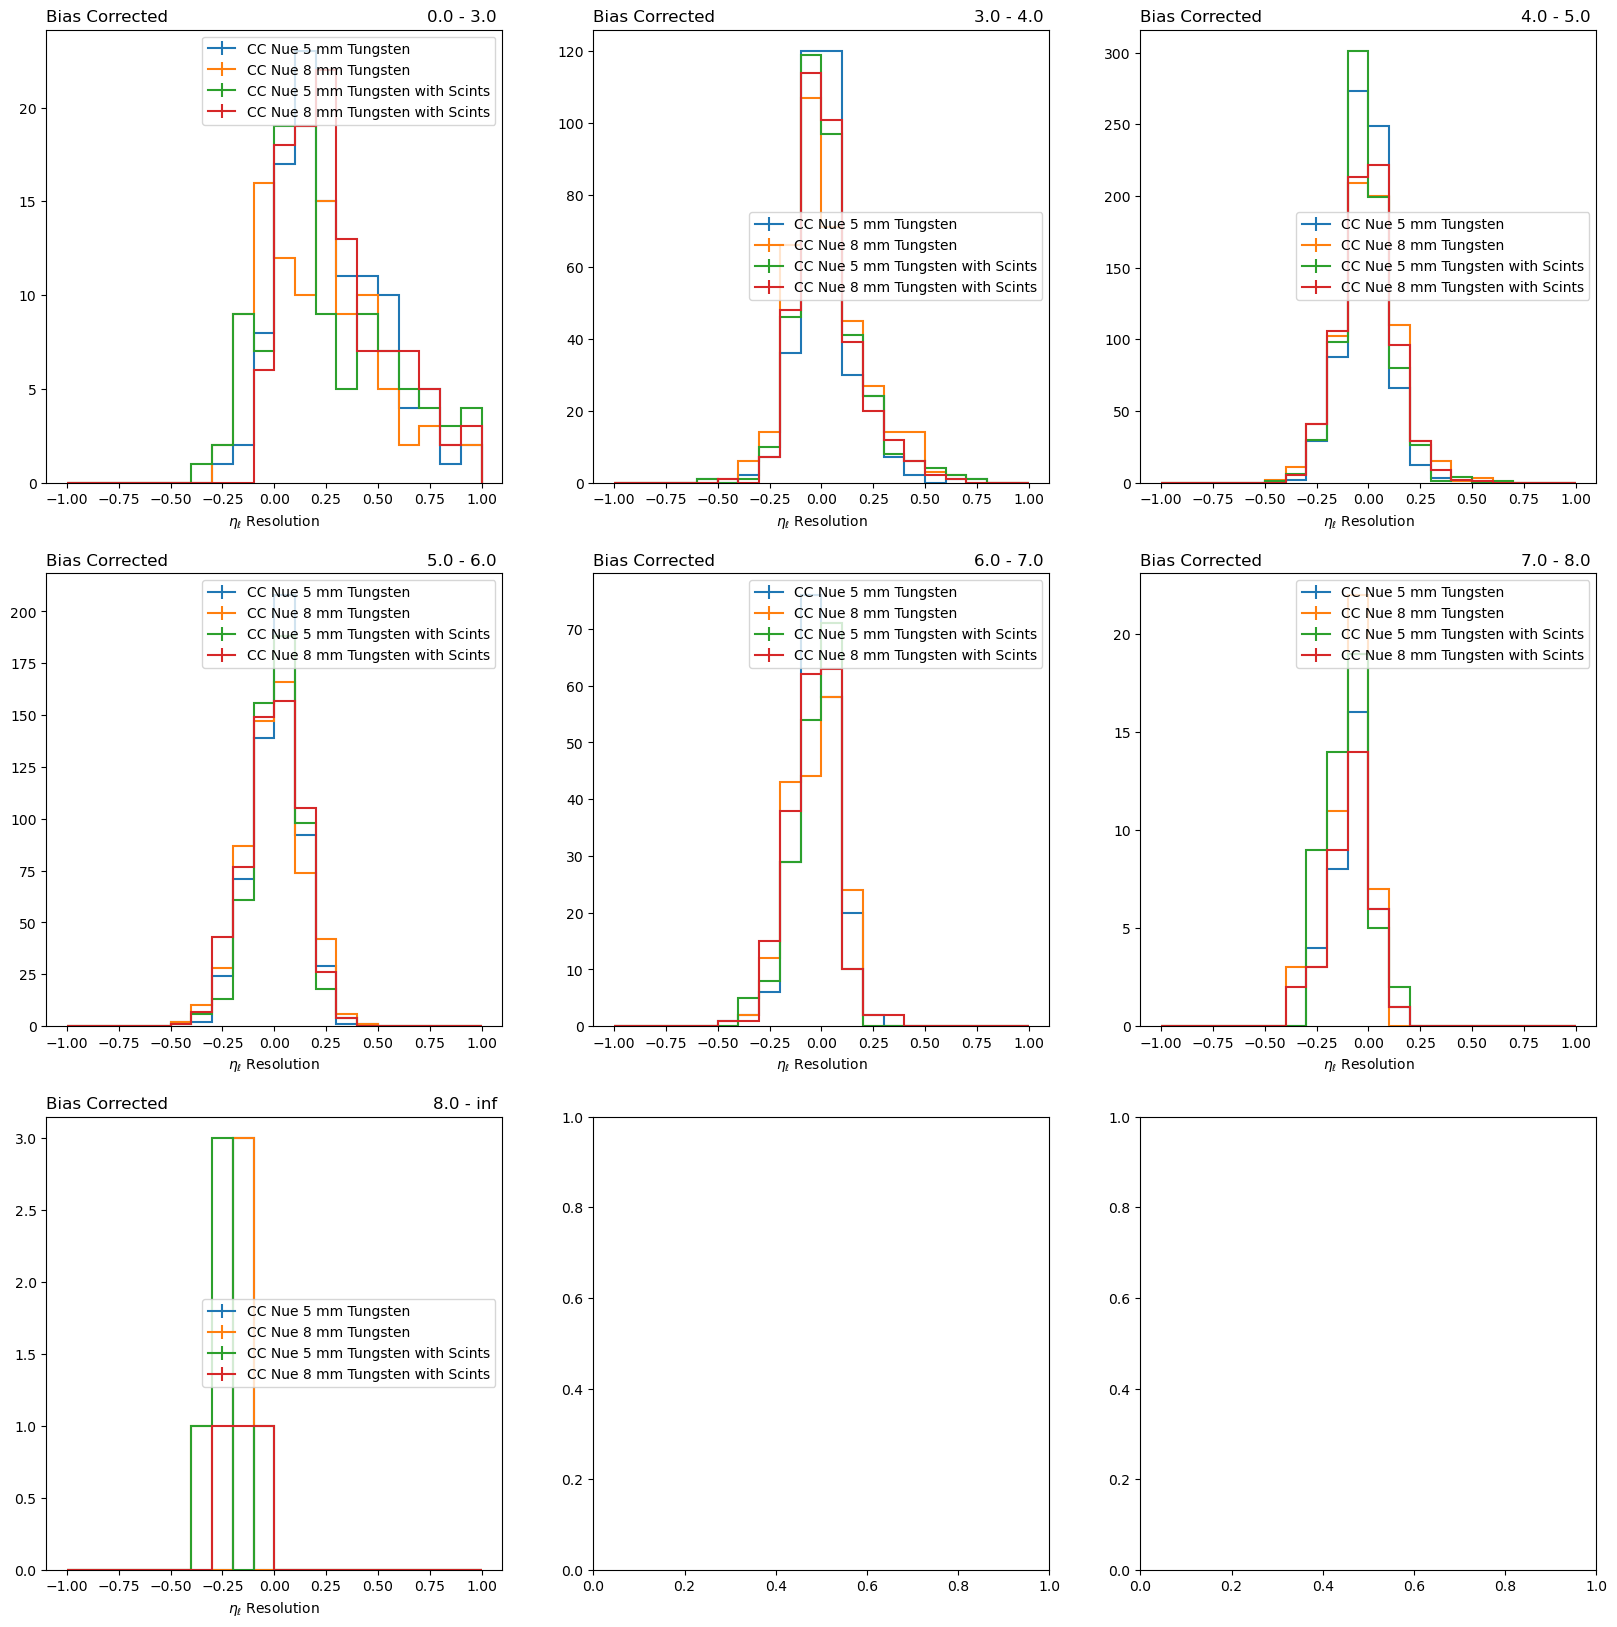

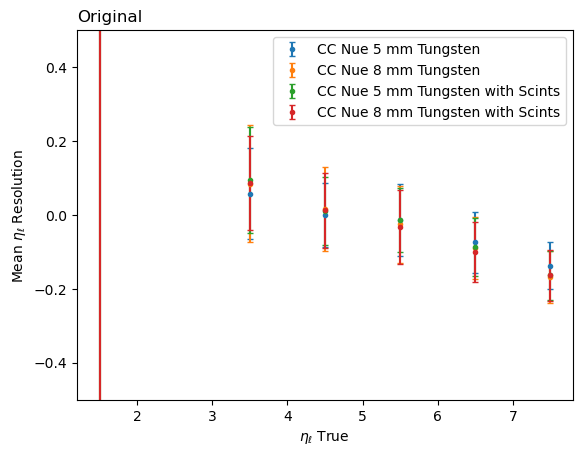

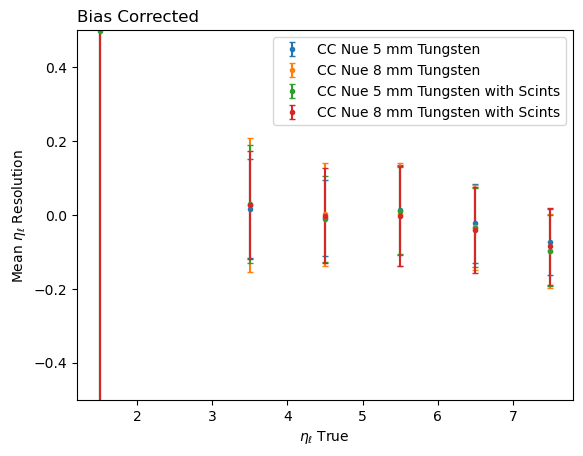

In [86]:
plot(hists, "Eta_lep", r"\eta_\ell", "")

IndexError: list index out of range

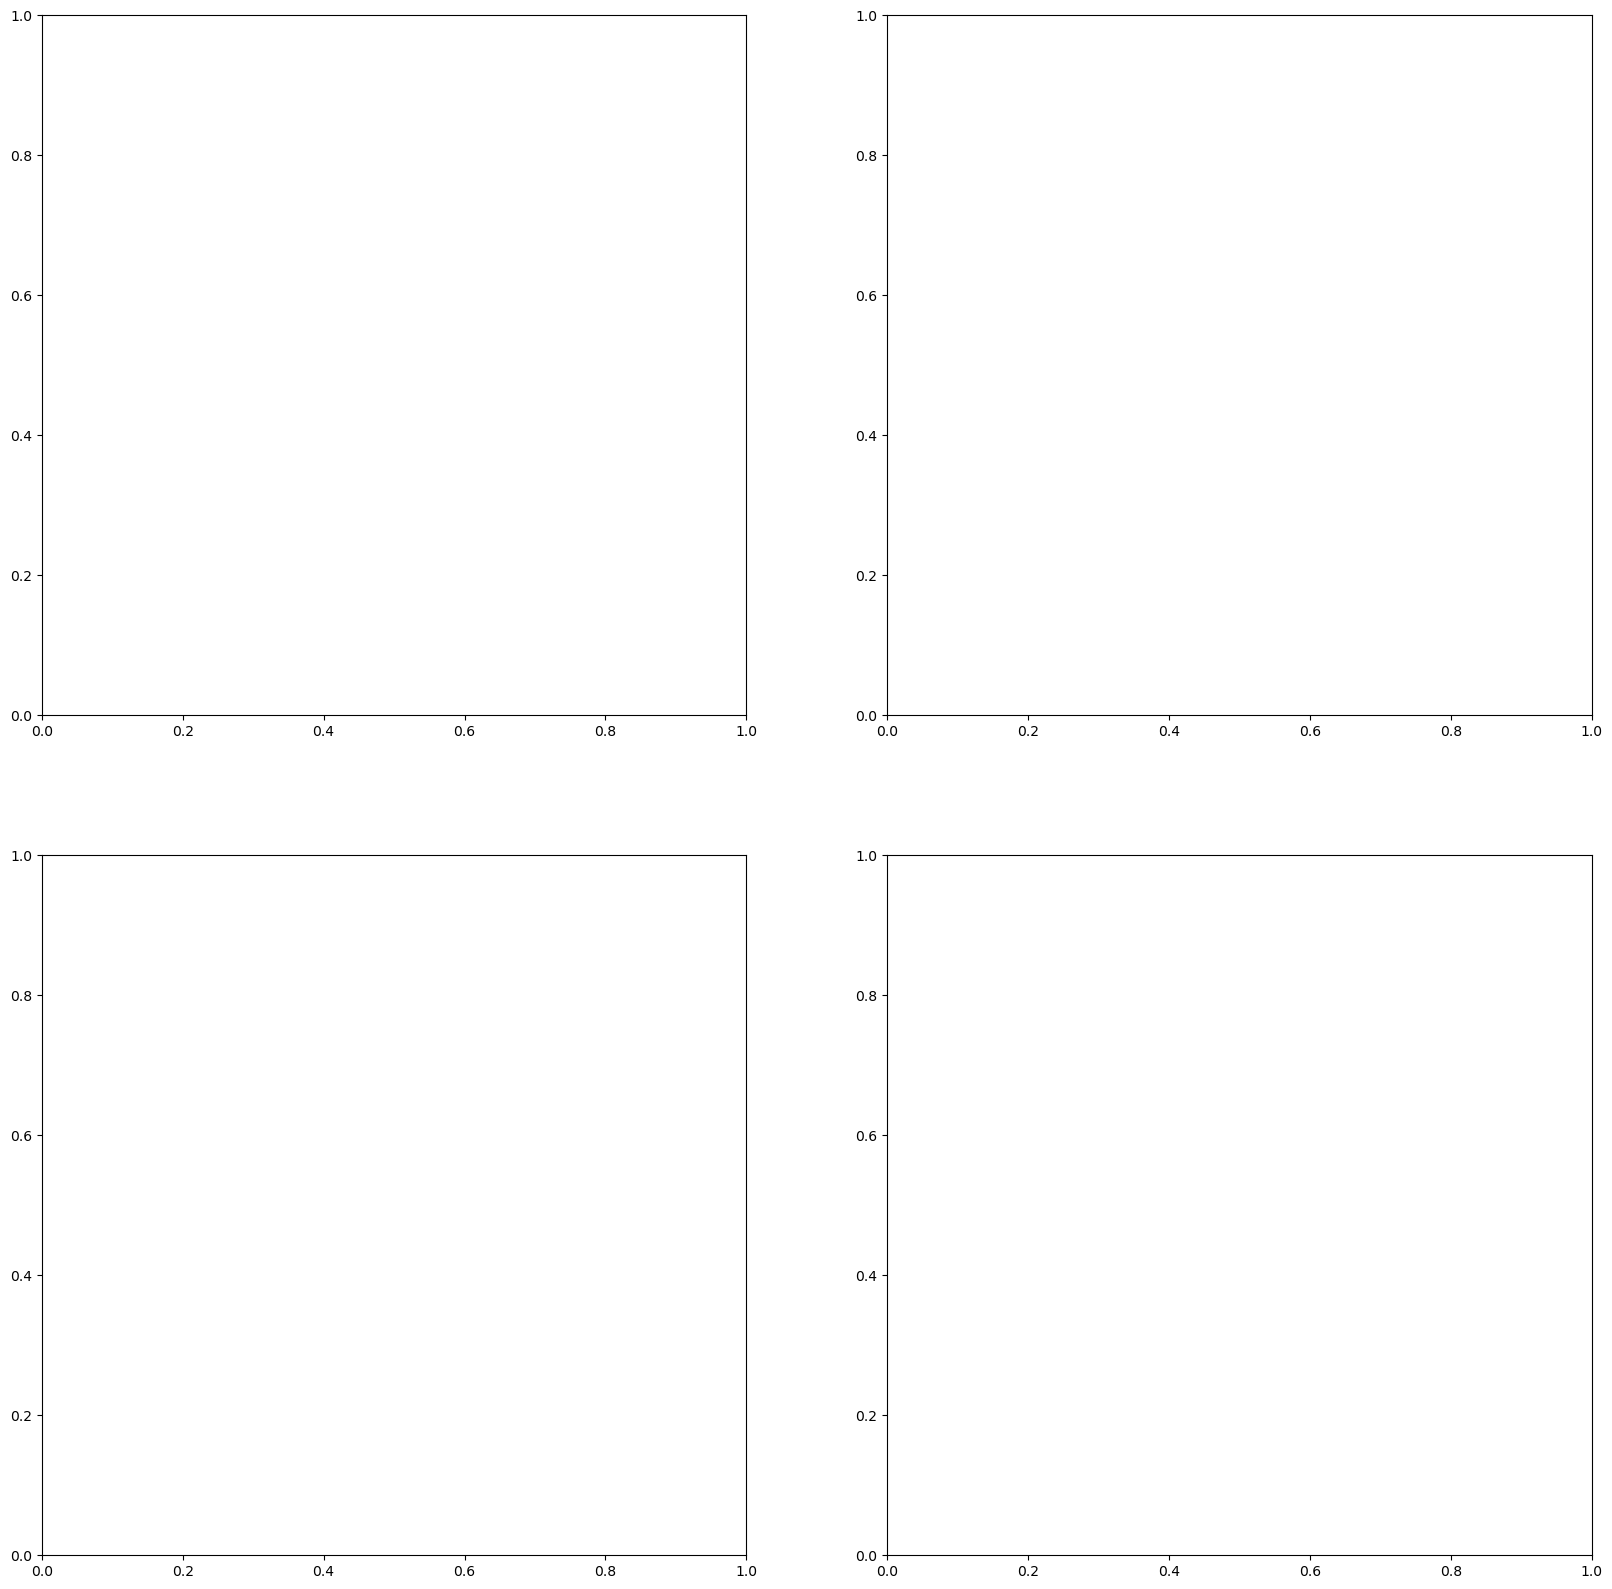

In [87]:
def plot(hists, varname, var_latex, units):
    hists_var = hists[varname]

    plot_true_v_reco(hists_var, 2, title="Original", var_latex=var_latex, unit=units)
    plot_true_v_reco(hists_var, 3, title="Bias Corrected", var_latex=var_latex, unit=units)

    plot_res_hists(hists_var, 0, title="Original", var_latex=var_latex, unit=units)
    plot_res_hists(hists_var, 1, title="Bias Corrected", var_latex=var_latex, unit=units)

    plot_stats(hists_var, 4, title="Original", var_latex=var_latex, unit=units)
    plot_stats(hists_var, 5, title="Bias Corrected", var_latex=var_latex, unit=units)

    

plot(hists, "E_had", r"E_\text{had}", "[GeV]")